# Pricing Exotic Options by using Monte Carlo Scheme

- *Author*: Zhixin Li

The task is to use the **expected value** of the <font color="sandybrown">discounted payoff</font> under the risk-neutral density $\mathbb{Q}$:
$$
V(S,t)=e^{-r(T-t)}\mathbb{E}^{\mathbb{Q}}[Payoff(S_T)]
$$
for the <font color="cornflowerblue">*Asian option*</font> and <font color="cornflowerblue">*Lookback option*</font> **payoff**.
- **Asian option**
    - The Asian option is a strongly path-dependent option. Its payoff depends on the <font color="sandybrown">average price</font> of the underlying asset over a certain period of time.
    - The Asian option has relatively lower volatility due to the average.
    - In general, the Asian options are less expensive than other standard options.
- **Lookback option**
    - The Lookback option has a payoff that depends on the <font color="sandybrown">maximum</font> or <font color="sandybrown">minimum</font> of the *realized* asset price.
    - The Lookback option is an option that allows the holder to exercise the option at the <font color="sandybrown">most beneficial price</font> of the underlying asset, over the life of the option.
    - The Lookback options are expensive to establish and the potential profits are often nullified by the costs.

### Using Monte Carlo Simulation under the Euler-Maruyama scheme
- **Euler-Maruyama Method**
<br>    The Euler-Maruyama method is a method for the approximate numerical solution of a stochastic differential equation (SDE). The SDE:
    $$
    dS=\mu Sdt+\sigma SdX
    $$
- **Monte Carlo Simulation**
    - The Monte Carlo Simulation is a numerical method that price the option by simulating the price of the underlying asset for plenty of times, then average the pricing result to get the approximation of the option price.
    - <font color="cornflowerblue">The simulation is for the underlying asset price.</font>
    - <font color="cornflowerblue">The option price is got from the average result.</font>
- **Target**
    <br>To price the <font color="cornflowerblue">*Asian option*</font> and <font color="cornflowerblue">*Lookback option*</font> with Monte Carlo Simulation.
- **Initial Data**
    $$
    \text{Today's stock price }S_0=100\\
    \text{Strike }E=100\\
    \text{Time to expiry }(T-t)=1\text{ year}\\
    \text{volatility }\sigma=20%\\
    \text{constant risk-free interest rate }r=5%
    $$

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
from numpy import random

# Libraries for plotting
import matplotlib.pyplot as plt
import cufflinks as cf

cf.set_config_file(offline=True)
# Set max row to 300
pd.set_option('display.max_rows', 300)

## Self-defined Functions

### Decorator

In [3]:
# A timing decorator
from datetime import datetime

def time_counter(func):
    def wrap(*arg, **kwargs):
        start = datetime.now()
        res = func(*arg, **kwargs)
        end = datetime.now()
        print("----- Time diff is: {} seconds -----".format((end - start).total_seconds()))
        return res
    return wrap

### Function

In [4]:
def random_picker(n_nums=10, start=0, end=100):
    """
    Pick out some samples randomly.
    :params n_nums: The number of samples to be picked out.
    :params start: The start number of the samples.
    :params end: The end number of the samples, should be less than the sample size.
    :return: The selected sample index number.
    """
    from random import randint

    picker = []
    while len(picker) < n_nums:
        gen_num = randint(start, end)
        if gen_num not in picker: picker.append(gen_num)
    return sorted(picker)

In [5]:
def graph_call_put_trend(x: np.array, y: dict, names: dict, title_name: str, fig_size=(18, 5), font_size=12):
    """
    Plot the call and put option valuation trend.
    :params x: The x-axis data.
    :params y: The option price data, stored in a dictionary, separated by "call" and "put".
    :params names: The option names, stored in a dictionary, separated by "call" and "put".
    :params title_name: The title names for the graph.
    :params fig_size: The figure size.
    :params font_size: The font size of the title, x and y axis label.
    """
    COLOR_LIST = ["lightsteelblue", "sandybrown", "mediumturquoise", "navajowhite"]
    x = np.array(x)
    fig = plt.figure(figsize=fig_size)
    axs = fig.subplots(nrows=1, ncols=2)
    for e, data in enumerate(y["call"]):
        data = np.array(list(map(float, data)))
        axs[0].plot(x, data, linewidth=3, alpha=0.8, color=COLOR_LIST[e], label="{}".format(names["call"][e]))
        axs[0].set_xlim(min(x), max(x))
        axs[0].set_xlabel("{}".format(title_name), fontsize=font_size)
        axs[0].set_ylabel("Call Option Value", fontsize=font_size)
        axs[0].set_title("Call Option Value with Different {}\n(same for the rest)".format(title_name), fontsize=font_size + 2)
        axs[0].grid(True)
        axs[0].legend()
    for e, data in enumerate(y["put"]):
        data = np.array(list(map(float, data)))
        axs[1].plot(x, data, linewidth=3, alpha=0.8, color=COLOR_LIST[e + 2], label="{}".format(names["put"][e]))
        axs[1].set_xlim(min(x), max(x))
        axs[1].set_xlabel("{}".format(title_name), fontsize=font_size)
        axs[1].set_ylabel("Put Option Value", fontsize=font_size)
        axs[1].set_title("Put Option Value with Different {}\n(same for the rest)".format(title_name), fontsize=font_size + 2)
        axs[1].grid(True)
        axs[1].legend()
    plt.show()

In [6]:
def vanilla_MC(simulation: np.array, pricing_ele: dict, cont_disc="cont", random_seed=1234):
    """
    Use No Variance reduction technique to reduce the variance of M.C.
    :params simulation: The matrix taht is going to be simulated.
    :params pricing_ele: The pricing elements.
        r - return
        sigma - volatility
        t - amount of time steps
        dt - time to maturity
        n - number of simulation times
    :params cont_disc: To decide which method to use in calculating the next asset price, the continuous one or discrete one. 
        Value should be "cont" or "disc".
        "cont" - continuous method.
        "disc" - discrete method.
    :return: The new simulation result with antithetic variance reduction.
    """
    random.seed(random_seed)
    print("===== Monte Carlo Simulation Without Variance Reduction =====")
    r, sigma, t, dt, n = pricing_ele["r"], pricing_ele["sigma"], pricing_ele["t"], pricing_ele["dt"], pricing_ele["n"]
    
    for i in range(t):
        z = random.standard_normal(n)
        if cont_disc not in ["cont", "disc"]:
            raise ValueError("Please input 'cont' or 'disc' to decide which method to use for deciding the next time step's asset price.")
        elif cont_disc == "cont":
            simulation[i + 1] = simulation[i] * np.exp((r - np.square(sigma) / 2) * dt + sigma * np.sqrt(dt) * z)
        elif cont_disc == "disc":
            simulation[i + 1] = simulation[i] * (1 + r * dt + np.sigma * np.sqrt(dt) * z)
            
    print("new data:{}".format(simulation.shape))
    return simulation

In [7]:
def antithetic_variance_reduction(simulation: np.array, pricing_ele: dict, cont_disc="cont", random_seed=1234):
    """
    Use Antithetic Variance reduction technique to reduce the variance of M.C.
    :params simulation: The matrix taht is going to be simulated.
    :params pricing_ele: The pricing elements.
        r - return
        sigma - volatility
        t - amount of time steps
        dt - time to maturity
        n - number of simulation times
    :params cont_disc: To decide which method to use in calculating the next asset price, the continuous one or discrete one. 
        Value should be "cont" or "disc".
        "cont" - continuous method.
        "disc" - discrete method.
    :return: The new simulation result with antithetic variance reduction.
    """
    random.seed(random_seed)
    print("===== Antithetic Variance Reduction =====")
    r, sigma, t, dt, n = pricing_ele["r"], pricing_ele["sigma"], pricing_ele["t"], pricing_ele["dt"], pricing_ele["n"]
    for i in range(t):
        z1 = random.standard_normal(n)
        z2 = -z1
        z = np.concatenate((z1, z2))
        if cont_disc not in ["cont", "disc"]:
            raise ValueError("Please input 'cont' or 'disc' to decide which method to use for deciding the next time step's asset price.")
        elif cont_disc == "cont":
            simulation[i + 1] = simulation[i] * np.exp((r - np.square(sigma) / 2) * dt + sigma * np.sqrt(dt) * z)
        elif cont_disc == "disc":
            simulation[i + 1] = simulation[i] * (1 + r * dt + np.sigma * np.sqrt(dt) * z)
    
    print("new data:{}".format(simulation.shape))
    return simulation

## Simulating Asset Price
- Under the risk neutral framework of BSM, a GBM with a stochastic differential equation (SDE) is given as
$$
dS_t=rS_tdt+\sigma S_tdZ_t
$$
<br>
- Applying Euler discretization of SDE (continuous)
$$
S_t=S_{t-\delta t}e^{(r-\frac{1}{2}\sigma ^2)\delta t+\sigma\phi\sqrt{\delta t}}
$$
<br>
- Applying Euler discretization of SDE (discrete)
$$
S_i=S_{i-1}\cdot(1+r\delta t+\sigma\phi\sqrt{\delta t})
$$

In [8]:
@time_counter
def simulate_path(s0: float, mu: float, sigma: float, horizon: int, timesteps: int, n_times: int, cont_disc="cont", var_reduce=None, random_seed=1234):
    """
    Simulate the underlying asset price using continuous function.
    :params s0: The underlying asset price at time t=0 (current), initial spot level.
    :params mu: The risk-free rate (under the risk neutral framework).
    :params sigma: The diffusion.
    :params horizon: The time horizon for the generated data.
    :params timesteps: The number of time steps.
    :params n_times: The number of the simulations.
    :params cont_disc: To decide which method to use in calculating the next asset price, the continuous one or discrete one. 
        Value should be "cont" or "disc".
        "cont" - continuous method.
        "disc" - discrete method.
    :params var_reduce: The variance reduction method, input string. "None" means will not use variance reduction.
        "antithetic": The Antithetic Variation reduction method.
    :params random_seed: The random seed.
    :return: The generated underlying asset time series with t time steps as rows and n_times as the number of the simulations.
    """
    random.seed(random_seed)
    
    S0, r, T, t, n = s0, mu, horizon, timesteps, n_times
    dt = T / t
    p_ele = {"r": r, "sigma": sigma, "t": t, "dt": dt, "n": n}
    
    # Initialize generated result
    S = np.zeros((t + 1, n)) # The first row is for the S0.
    S[0] = S0
    
    if var_reduce:
        if var_reduce.lower() == "antithetic":
            S = np.concatenate((S, S), axis=1)
            S = antithetic_variance_reduction(S, p_ele, cont_disc, random_seed)
    else:
        S = vanilla_MC(S, p_ele, cont_disc, random_seed)

    return S

### Settings

In [9]:
SIMULATION = "cont"
S0 = 100
E = 100
T = 1
t = 252
sigma = 0.2
r = 0.05
N = 100000

### Generate the underlying asset price

- **Simple Monte Carlo Simulation**

In [10]:
spath = simulate_path(S0, r, sigma, T, t, N)
print("spath: {}".format(spath.shape))

===== Monte Carlo Simulation Without Variance Reduction =====
new data:(253, 100000)
----- Time diff is: 0.981587 seconds -----
spath: (253, 100000)


- **Monte Carlo Simulation with Antithetic Variance Reduction**

In [11]:
av_spath = simulate_path(S0, r, sigma, T, t, N, var_reduce="Antithetic")
print("spath: {}".format(av_spath.shape))

===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.445669 seconds -----
spath: (253, 200000)


#### Visualize the generated asset price

- **Histogram**

In [12]:
def graph_asset_price_distribution(price: list, obj_names: list, rows: int, cols: int, bins=50, fig_size=(18, 9), font_size=16):
    """
    Draw the asset price distribution, can be a combination of several distributions.
    :params price: The price series, should be a list containing the price series that are going to be plotted.
    :params obj_names: The name list of the objective that are going to be plotted.
    :params rows: The number of rows for the combination graphs.
    :params cols: The number of columns for the combination graphs.
    :params bins: The number of bins in distribution graphs.
    :params fig_size: The figure size.
    :params font_size: Font size of the x and y axes labels.
    """
    if not isinstance(price, list): raise TypeError("Please input a list for price.")
    if not isinstance(obj_names, list): raise TypeError("Please input a list for obj_names.")
    if not obj_names: obj_names = ["" for i in range(rows * cols)]

    fig = plt.figure(figsize=fig_size)
    if rows == 1 and cols == 1:
        plt.hist(price[0], bins=bins, edgecolor="white", color="sandybrown")
        plt.xlabel("{} Price".format(obj_names[0]), fontsize=font_size)
        plt.ylabel("Frequency", fontsize=font_size)
        plt.title("{} Distributions".format(obj_names[0]), fontsize=font_size + 4)
        plt.grid(True)
    elif rows == 1:
        axs = fig.subplots(nrows=rows, ncols=cols)
        for pos in range(cols):
            axs[pos].hist(price[pos], bins=bins, edgecolor="white", color="sandybrown")
            axs[pos].set_xlabel("{} Price".format(obj_names[pos]), fontsize=font_size)
            axs[pos].set_ylabel("Frequency", fontsize=font_size)
            axs[pos].set_title("{} Distributions".format(obj_names[pos]), fontsize=font_size + 4)
            axs[pos].grid(True)
    else:
        axs = fig.subplots(nrows=rows, ncols=cols)
        num = 0
        for row in range(rows):
            for col in range(cols):
                if num == len(price): break
                axs[row][col].hist(price[num], bins=bins, edgecolor="white", color="sandybrown")
                axs[row][col].set_xlabel("{} Price".format(obj_names[num]), fontsize=font_size)
                axs[row][col].set_ylabel("Frequency", fontsize=font_size)
                axs[row][col].set_title("{} Distributions".format(obj_names[num]), fontsize=font_size + 4)
                axs[row][col].grid(True)
                num += 1
    plt.show()

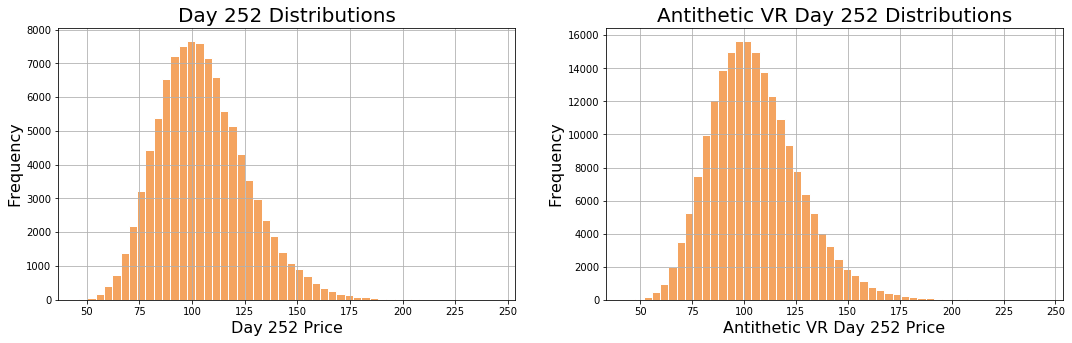

In [13]:
graph_asset_price_distribution([spath[-1], av_spath[-1]], ["Day 252", "Antithetic VR Day 252"], rows=1, cols=2, fig_size=(18, 5))

- **Paths sample**

In [14]:
def graph_simulated_GBM(data_list: list, obj_names: list, rows: int, cols: int, bins=50, fig_size=(18, 6), font_size=16):
    """
    Draw the simulated asset price (GBM) path, can be a combination of several distributions.
    :params data_list: The list that contains the asset price paths dataframe.
    :params obj_names: The name list of the objective that are going to be plotted.
    :params rows: The number of rows for the combination graphs.
    :params cols: The number of columns for the combination graphs.
    :params bins: The number of bins in distribution graphs.
    :params fig_size: The figure size.
    :params font_size: Font size of the x and y axes labels.
    """
    if not isinstance(data_list, list): raise TypeError("Please input a list for data.")
    if not isinstance(obj_names, list): raise TypeError("Please input a list for obj_names.")
    if not obj_names: obj_names = ["" for i in range(rows * cols)]
    COLOR_LIST = ["lightblue", "lightcoral", "khaki", "lightgray", "lightgreen", "lightpink", "lightsalmon", 
                  "lightseagreen", "lightskyblue", "lightsteelblue", "sandybrown", "mediumturquoise", "navajowhite", 
                  "palegoldenrod", "palegreen", "pink", "plum", "steelblue", "yellowgreen"]

    fig = plt.figure(figsize=fig_size)
    if rows == 1 and cols == 1:
        df = data_list[0]
        for e, col in enumerate(df):
            data = df[col]
            plt.plot(data, linewidth=2, alpha=0.8, color=COLOR_LIST[e % len(COLOR_LIST)], label="{}".format(col))
        plt.xlabel("{} Price".format(obj_names[0]), fontsize=font_size)
        plt.ylabel("Frequency", fontsize=font_size)
        plt.xlim(0, len(df) + int(len(df) * 0.1))
        plt.title("{} Price Path".format(obj_names[0]), fontsize=font_size + 4)
        plt.legend(loc="right")
        plt.grid(True)
    elif rows == 1 or cols == 1:
        axs = fig.subplots(nrows=rows, ncols=cols)
        nums = max(rows, cols)
        for pos in range(nums):
            df = data_list[pos]
            for e, col in enumerate(df):
                data = df[col]
                axs[pos].plot(data, linewidth=2, alpha=0.8, color=COLOR_LIST[e % len(COLOR_LIST)], label="{}".format(col))
            axs[pos].set_xlabel("{} Price".format(obj_names[pos]), fontsize=font_size)
            axs[pos].set_ylabel("Frequency", fontsize=font_size)
            axs[pos].set_xlim(0, len(df) + int(len(df) * 0.1))
            axs[pos].set_title("{} Price Path".format(obj_names[pos]), fontsize=font_size + 4)
            axs[pos].legend(loc="right")
            axs[pos].grid(True)
    else:
        axs = fig.subplots(nrows=rows, ncols=cols)
        num = 0
        for row in range(rows):
            for col in range(cols):
                if num == len(data_list): break
                df = data_list[num]
                for e, col in enumerate(df):
                    data = df[col]
                    axs[row, col].plot(data, linewidth=2, alpha=0.8, color=COLOR_LIST[e % len(COLOR_LIST)], label="{}".format(col))
                axs[row, col].set_xlabel("{} Price".format(obj_names[pos]), fontsize=font_size)
                axs[row, col].set_ylabel("Frequency", fontsize=font_size)
                axs[row, col].set_xlim(0, len(df) + int(len(df) * 0.1))
                axs[row, col].set_title("{} Price Path".format(obj_names[pos]), fontsize=font_size + 4)
                axs[row, col].legend(loc="right")
                axs[row, col].grid(True)
                num += 1
    plt.show()

- **Randomly select some samples to plot paths**

In [15]:
# Vanilla simulation
spath_df = pd.DataFrame(spath)
picker_v = random_picker(n_nums=20, start=0, end=spath_df.shape[1])

In [16]:
# Simulation with Antithetic Variance Reduction
av_spath_df = pd.DataFrame(av_spath)
picker_av = random_picker(n_nums=20, start=0, end=av_spath_df.shape[1])

- **Draw a path graph**

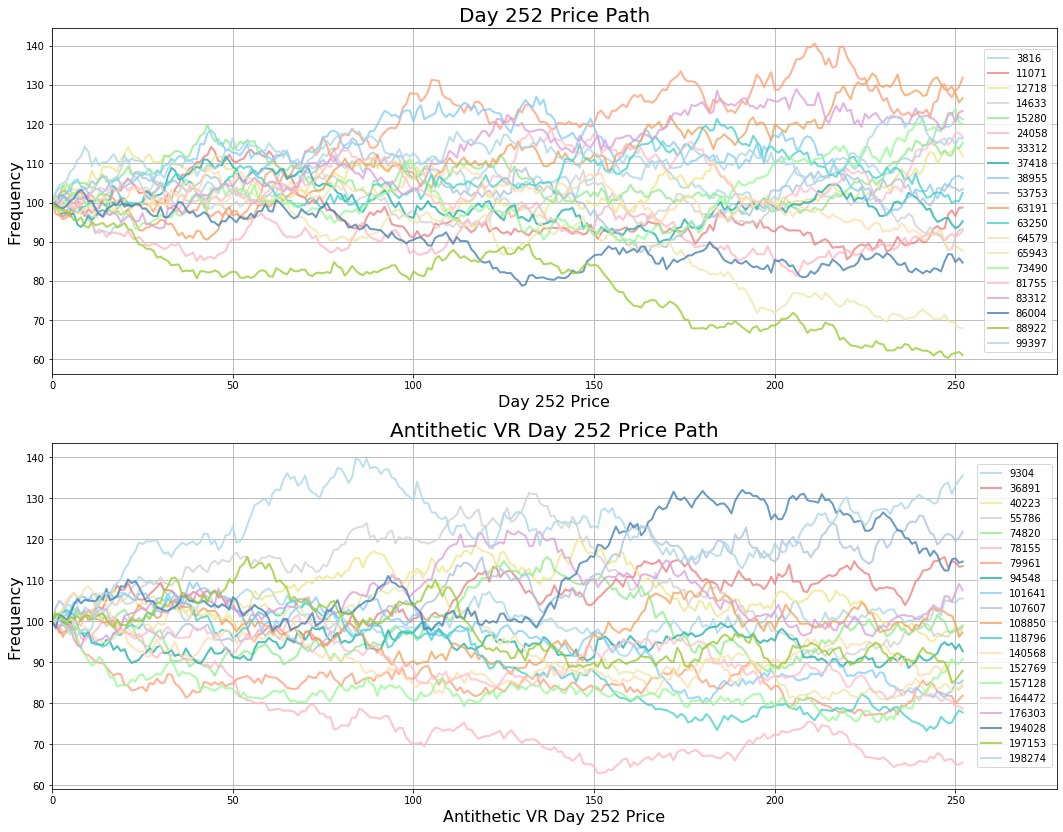

In [17]:
graph_simulated_GBM([spath_df.iloc[:, picker_v], av_spath_df.iloc[:, picker_av]], 
                    ["Day 252", "Antithetic VR Day 252"], 
                    rows=2, cols=1, fig_size=(18, 14))

## Risk Neutral Valuation

### Asian Option

- Call option price:
$$
C_T=max(0, \frac{\sum^n_{i=0}S_i}{n}-K)
$$
<br>
- Put option price:
$$
P_T=max(0, K-\frac{\sum^n_{i=0}S_i}{n})
$$
<br>
- Monte Carlo simulation: the **expected value of the future payoff**:
$$
C=PV(E[max(0, \frac{\sum^n_{i=0}S_i}{n}-K)])=e^{-r(T-t)}(E[max(0,\frac{\sum^n_{i=0}S_i}{n}-K)])
$$
$$
P=PV(E[max(0, K-\frac{\sum^n_{i=0}S_i}{n})])=e^{-r(T-t)}(E[max(0,K-\frac{\sum^n_{i=0}S_i}{n})])
$$

In [18]:
@time_counter
def Asian_call_put_valuation(simulation: np.array, strike: float, rf: float, tau: float, print_output=True):
    """
    Calculate the Asian call and put price for given simulated result, strike, risk-free interest rate, and time to maturity.
    :params simulation: The simulated underlying asset price, rows are time step price, columns are simulated number.
    :params strike: The strike price.
    :params rf: Risk-free interest rate.
    :params tau: Time to maturity.
    :params print_output: Whether to print the call and put price.
    :return: The call and put price of the Asian option.
    """
    S, K, r, t = simulation, strike, rf, tau
    
    avg_S = np.mean(S, axis=0)
    c = np.exp(-r * t) * np.mean(np.maximum(avg_S - K, 0))
    p = np.exp(-r * t) * np.mean(np.maximum(K - avg_S, 0))
    
    # Print the values
    if print_output:
        print("The European Call Option Value is: {}".format(round(c, 3)))
        print("The European Put Option Value is: {}".format(round(p, 3)))
    
    return c, p

In [19]:
asian_call, asian_put = Asian_call_put_valuation(spath, E, r, T)

The European Call Option Value is: 5.787
The European Put Option Value is: 3.349
----- Time diff is: 0.028167 seconds -----


### Lookback Option

<font color="red">**[NOTE]**</font>
Since the strike price is give, we assume to just focus on Lookback option with <font color="red">fixed strike</font>.

In [20]:
@time_counter
def Lookback_call_put_valuation(simulation: np.array, strike: float, rf: float, tau: float, print_output=True):
    """
    Calculate the Lookback call and put price for given simulated result, strike, risk-free interest rate, and time to maturity.
    :params simulation: The simulated underlying asset price, rows are time step price, columns are simulated number.
    :params strike: The strike price.
    :params rf: Risk-free interest rate.
    :params tau: Time to maturity.
    :params print_output: Whether to print the call and put price.
    :return: The call and put price of the Asian option.
    """
    S, K, r, t = simulation, strike, rf, tau
    
    # Call
    max_S = np.max(S, axis=0)
    c = np.exp(-r * t) * np.mean(np.maximum(max_S - K, 0))
    
    # Put
    min_S = np.min(S, axis=0)
    p = np.exp(-r * t) * np.mean(np.maximum(K - min_S, 0))
    
    # Print the values
    if print_output:
        print("The European Call Option Value is: {}".format(round(c, 3)))
        print("The European Put Option Value is: {}".format(round(p, 3)))
    
    return c, p

In [21]:
lookback_call, lookback_put = Lookback_call_put_valuation(spath, E, r, T)

The European Call Option Value is: 18.39
The European Put Option Value is: 11.745
----- Time diff is: 0.097736 seconds -----


# Various Parameters - Option Price Comparison

<font color="sandybrown">Only using Antithetic Variance Reduction Monte Carlo Simulation in the comparison.</font>

## 1. Underlying Asset Price

In [22]:
# Settings
SIMULATION = "cont"
S0_list = list(np.arange(90, 112.5, 2.5))
E = 100
T = 1
t = 252
sigma = 0.2
r = 0.05
N = 100000

In [23]:
S0_list

[90.0, 92.5, 95.0, 97.5, 100.0, 102.5, 105.0, 107.5, 110.0]

In [24]:
# Simulate the asset price
spath_list = []
for S0 in S0_list:
    spath_list.append(simulate_path(S0, r, sigma, T, t, N, var_reduce="Antithetic"))

===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.499075 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.479798 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.476378 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 2.039309 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.680794 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.768267 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.791362 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.854814 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.828356 seconds -----


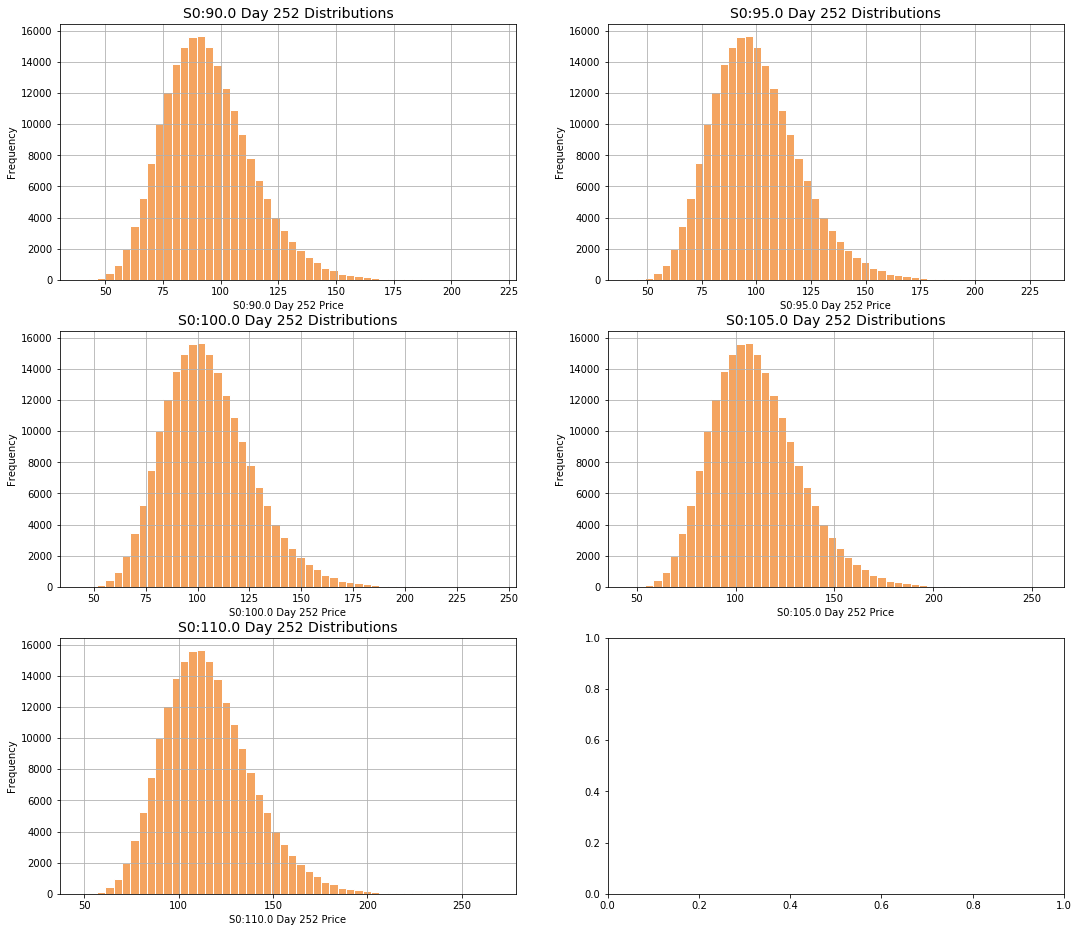

In [25]:
graph_list = [i[-1] for e, i in enumerate(spath_list) if e % 2 == 0]
name_list = ["S0:{} Day 252".format(i) for e, i in enumerate(S0_list) if e % 2 == 0]
graph_asset_price_distribution(graph_list, name_list, 
                               rows=3, cols=2, fig_size=(18, 16), font_size=10)

Just a shift of the maturity date asset price distributions along the x-axis (asset price axis) between different underlying asset price.

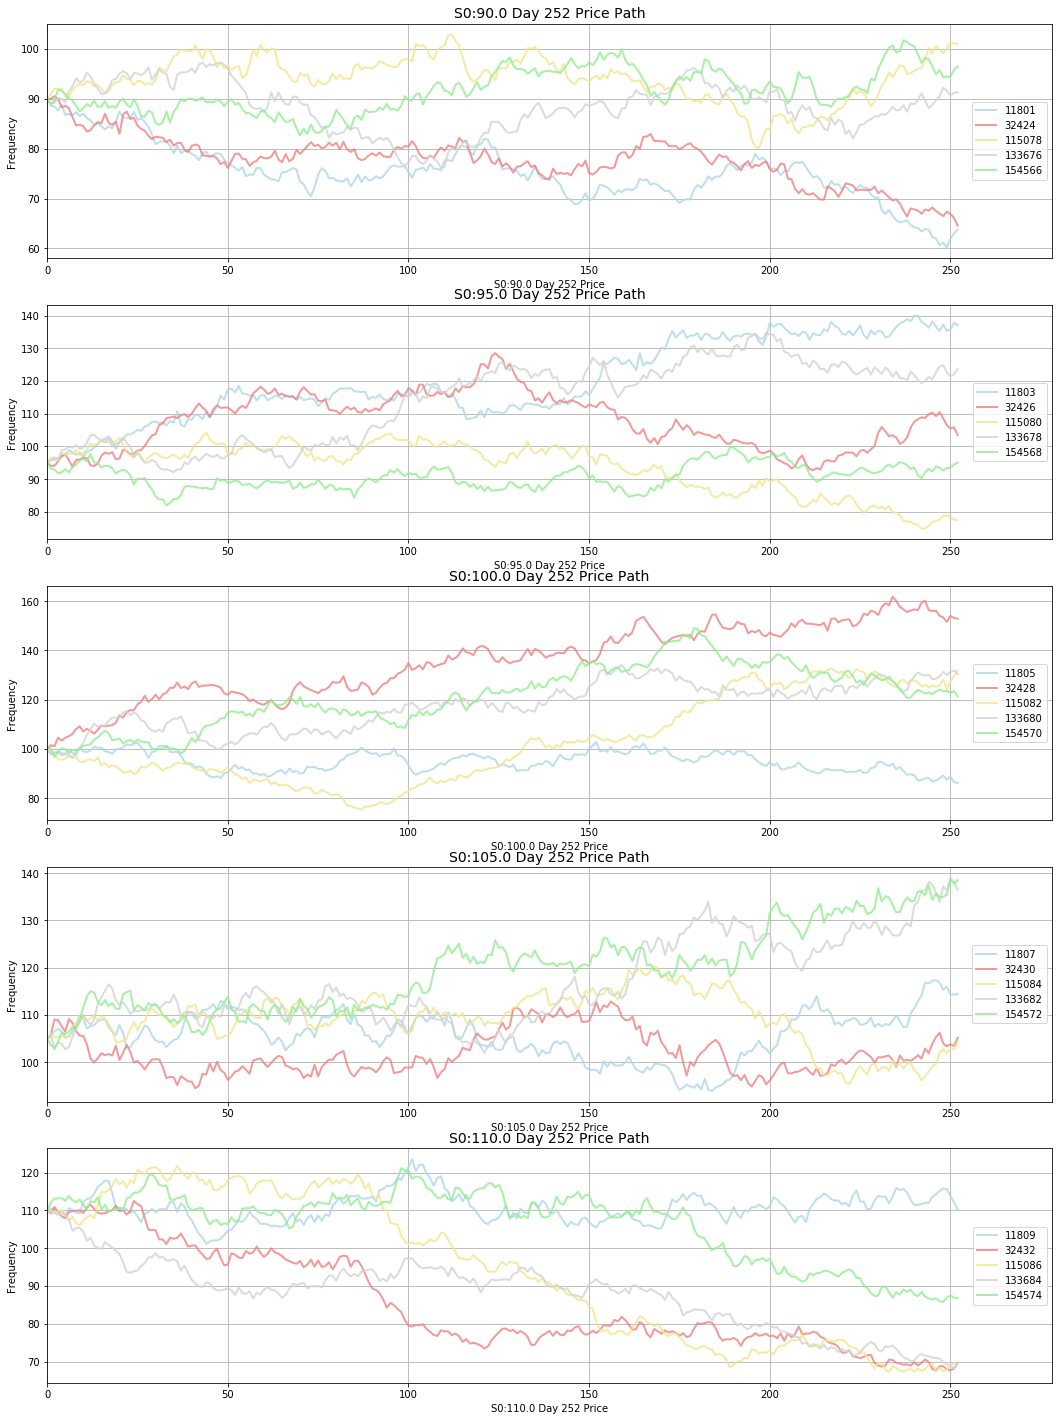

In [26]:
# Simulation with Antithetic Variance Reduction
spath_df = pd.DataFrame(spath_list[0])
picker = random_picker(n_nums=5, start=0, end=spath_df.shape[1])
graph_list = [pd.DataFrame(i).iloc[:, [min(i.shape[1], j + e) for j in picker]] for e, i in enumerate(spath_list) if e % 2 == 0]
graph_simulated_GBM(graph_list, name_list, rows=5, cols=1, fig_size=(18, 25), font_size=10)

In [27]:
# # Risk Neutral Valuation
cols_arr = [
    np.array(["Asian Option", "Asian Option", "Lookback Option", "Lookback Option"]),
    np.array(["Call", "Put", "Call", "Put"])
]
S0_res = pd.DataFrame(columns=cols_arr, index=pd.Series(S0_list, name="Asset Price"))
for e, spath in enumerate(spath_list):
    print("\n===== The current asset price is {} =====".format(S0_list[0]))
    # Asian Option
    print("Asian Option:")
    asian_call, asian_put = Asian_call_put_valuation(spath, E, r, T, print_output=False)
    # Lookback Option
    print("\nLookback Option:")
    lookback_call, lookback_put = Lookback_call_put_valuation(spath, E, r, T, print_output=False)
    S0_res.loc[S0_list[e]] = ["%.3f"%asian_call, "%.3f"%asian_put, "%.3f"%lookback_call, "%.3f"%lookback_put]
print("With\n   strike is {}\n   time to maturity is {} year\n   time steps is {}\n   volatility is {}\n   risk-free rate is {}".
      format(E, T, t, sigma, r))
print("\nThe Asian Options and Lookback Option call & put prices with different current asset price:")
display(S0_res)


===== The current asset price is 90.0 =====
Asian Option:
----- Time diff is: 0.373245 seconds -----

Lookback Option:
----- Time diff is: 0.156589 seconds -----

===== The current asset price is 90.0 =====
Asian Option:
----- Time diff is: 0.296196 seconds -----

Lookback Option:
----- Time diff is: 0.153176 seconds -----

===== The current asset price is 90.0 =====
Asian Option:
----- Time diff is: 0.28664 seconds -----

Lookback Option:
----- Time diff is: 0.155051 seconds -----

===== The current asset price is 90.0 =====
Asian Option:
----- Time diff is: 0.292688 seconds -----

Lookback Option:
----- Time diff is: 0.155713 seconds -----

===== The current asset price is 90.0 =====
Asian Option:
----- Time diff is: 0.281964 seconds -----

Lookback Option:
----- Time diff is: 0.15616 seconds -----

===== The current asset price is 90.0 =====
Asian Option:
----- Time diff is: 0.229374 seconds -----

Lookback Option:
----- Time diff is: 0.16183 seconds -----

===== The current asset 

Asian Option        Lookback Option        
                    Call    Put            Call     Put
Asset Price                                            
90.0               1.577  8.907           8.980  20.092
92.5               2.313  7.204          10.988  18.007
95.0               3.253  5.706          13.229  15.923
97.5               4.410  4.425          15.695  13.839
100.0              5.778  3.354          18.371  11.755
102.5              7.349  2.486          21.208   9.893
105.0              9.104  1.802          24.045   8.284
107.5             11.017  1.277          26.883   6.903
110.0             13.064  0.885          29.720   5.729

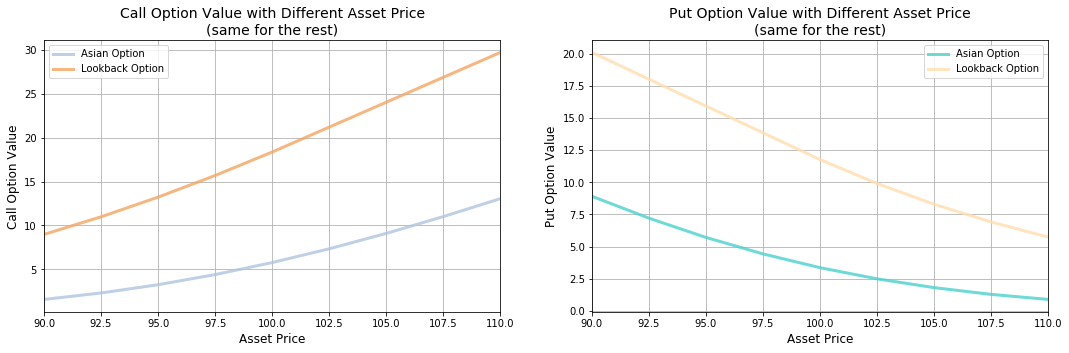

In [28]:
# Graphs of the call & put price on different strikes
x = np.array(S0_res.index)
y = {
    "call": [S0_res.loc[:, ("Asian Option", "Call")], S0_res.loc[:, ("Lookback Option", "Call")]],
    "put": [S0_res.loc[:, ("Asian Option", "Put")], S0_res.loc[:, ("Lookback Option", "Put")]]
}
names = {"call": ["Asian Option", "Lookback Option"], "put": ["Asian Option", "Lookback Option"]}
graph_call_put_trend(x, y, names, "Asset Price", fig_size=(18, 5))

From the graphs above, we can see that, when other conditions are fixed (Strike, time to maturity, time steps, volatility, and risk-free rate), there are several differences:
- Both the call and put options prices and strike prices are positively correlated.
- The curve is non-linear, meaning that the option price changes in different scales as the asset price changes.
- The higher the asset price is, the higher the growth rate of the call option value.
- The higher the asset price is, the lower the growth rate of the put option value.
- The price gaps between Asian calls and Lookback calls are greater than the ones on puts.
    - ITM options tends to have larger gaps, while OTM options tends to have smaller gaps.

## 2. Strike Price

In [29]:
# Settings
SIMULATION = "cont"
S0 = 100
E_list = list(np.arange(90, 112.5, 2.5))
T = 1
t = 252
sigma = 0.2
r = 0.05
N = 100000

In [30]:
# Simulate the asset price
spath = simulate_path(S0, r, sigma, T, t, N, var_reduce="Antithetic")
print("spath: {}".format(spath.shape))

===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 2.359024 seconds -----
spath: (253, 200000)


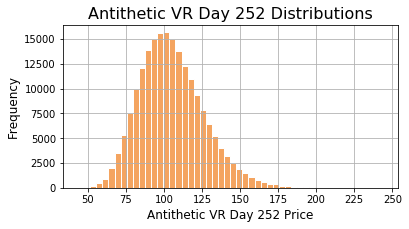

In [31]:
graph_asset_price_distribution([spath[-1]], ["Antithetic VR Day 252"], rows=1, cols=1, fig_size=(6, 3), font_size=12)

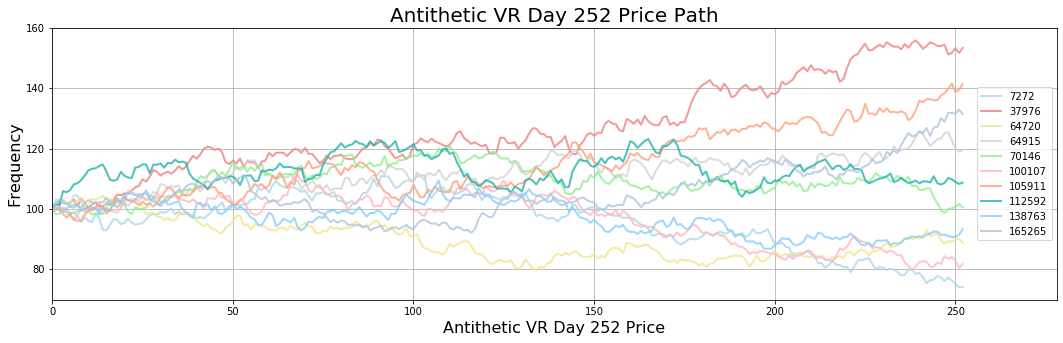

In [32]:
# Simulation with Antithetic Variance Reduction
spath_df = pd.DataFrame(spath)
picker = random_picker(n_nums=10, start=0, end=spath_df.shape[1])
graph_simulated_GBM([spath_df.iloc[:, picker]], ["Antithetic VR Day 252"], rows=1, cols=1, fig_size=(18, 5))

In [33]:
# # Risk Neutral Valuation
cols_arr = [
    np.array(["Asian Option", "Asian Option", "Lookback Option", "Lookback Option"]),
    np.array(["Call", "Put", "Call", "Put"])
]
E_res = pd.DataFrame(columns=cols_arr, index=pd.Series(E_list, name="Strike"))
for E in E_list:
    print("\n===== The strike price is {} =====".format(E))
    # Asian Option
    print("Asian Option:")
    asian_call, asian_put = Asian_call_put_valuation(spath, E, r, T, print_output=False)
    # Lookback Option
    print("\nLookback Option:")
    lookback_call, lookback_put = Lookback_call_put_valuation(spath, E, r, T, print_output=False)
    E_res.loc[E] = ["%.3f"%asian_call, "%.3f"%asian_put, "%.3f"%lookback_call, "%.3f"%lookback_put]
print("With\n   current asset price is {}\n   time to maturity is {} year\n   time steps is {}\n   volatility is {}\n   risk-free rate is {}".format(S0, T, t, sigma, r))
print("\nThe Asian Options and Lookback Option call & put prices with different Strikes:")
display(E_res)


===== The strike price is 90.0 =====
Asian Option:
----- Time diff is: 0.066497 seconds -----

Lookback Option:
----- Time diff is: 0.181307 seconds -----

===== The strike price is 92.5 =====
Asian Option:
----- Time diff is: 0.042708 seconds -----

Lookback Option:
----- Time diff is: 0.168809 seconds -----

===== The strike price is 95.0 =====
Asian Option:
----- Time diff is: 0.115141 seconds -----

Lookback Option:
----- Time diff is: 0.35409 seconds -----

===== The strike price is 97.5 =====
Asian Option:
----- Time diff is: 0.034953 seconds -----

Lookback Option:
----- Time diff is: 0.164441 seconds -----

===== The strike price is 100.0 =====
Asian Option:
----- Time diff is: 0.038987 seconds -----

Lookback Option:
----- Time diff is: 0.158474 seconds -----

===== The strike price is 102.5 =====
Asian Option:
----- Time diff is: 0.035258 seconds -----

Lookback Option:
----- Time diff is: 0.162787 seconds -----

===== The strike price is 105.0 =====
Asian Option:
----- Time

Asian Option        Lookback Option        
               Call    Put            Call     Put
Strike                                            
90.0         12.609  0.672          27.883   4.739
92.5         10.641  1.082          25.505   6.105
95.0          8.833  1.653          23.127   7.722
97.5          7.207  2.404          20.749   9.602
100.0         5.778  3.354          18.371  11.755
102.5         4.552  4.506          16.152  14.133
105.0         3.522  5.854          14.127  16.511
107.5         2.679  7.389          12.296  18.889
110.0         2.004  9.092          10.651  21.267

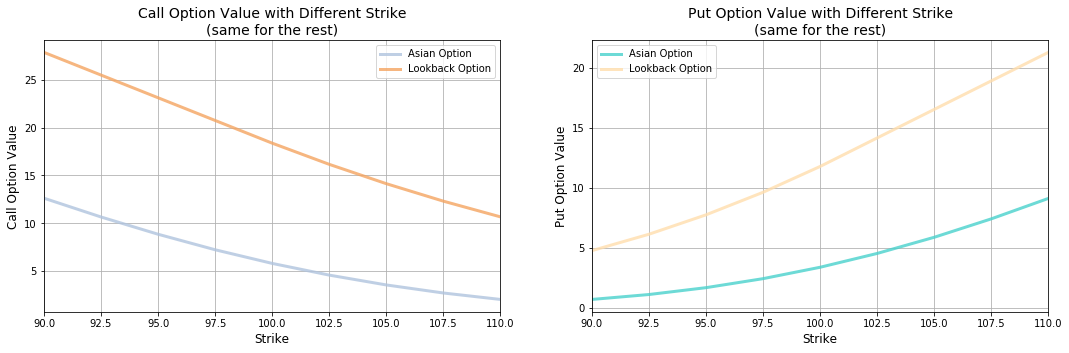

In [34]:
# Graphs of the call & put price on different strikes
x = np.array(E_res.index)
y = {
    "call": [E_res.loc[:, ("Asian Option", "Call")], E_res.loc[:, ("Lookback Option", "Call")]],
    "put": [E_res.loc[:, ("Asian Option", "Put")], E_res.loc[:, ("Lookback Option", "Put")]]
}
names = {"call": ["Asian Option", "Lookback Option"], "put": ["Asian Option", "Lookback Option"]}
graph_call_put_trend(x, y, names, "Strike", fig_size=(18, 5))

From the graphs above, we can see that, when other conditions are fixed (current asset price, time to maturity, time steps, volatility, and risk-free rate), there are several differences:
- The call option prices and strike prices are negatively correlated, while put option prices are positively correlated with the strike prices.
- The curve is non-linear, meaning that the option price changes in different scales as the strike changes. The call price decrease slighter with the increase of the strike, while the put price is the opposite. OTM options tends to change more moderate and ITM options tends to change more sharply.
- The price gap between Asian calls and Lookback calls are greater than the ones on puts.

## 3. Time to Maturity

In [35]:
# Settings
SIMULATION = "cont"
S0 = 100
E = 100
T_list = list(np.arange(0.5, 3.5, 0.5))
t_list = [int(252 * i) for i in np.arange(0.5, 3.5, 0.5)]
sigma = 0.2
r = 0.05
N = 100000

In [36]:
# Simulate the asset price
spath_list = []
for i in range(len(T_list)):
    spath_list.append(simulate_path(S0, r, sigma, T_list[i], t_list[i], N, var_reduce="Antithetic"))

===== Antithetic Variance Reduction =====
new data:(127, 200000)
----- Time diff is: 0.707633 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.43217 seconds -----
===== Antithetic Variance Reduction =====
new data:(379, 200000)
----- Time diff is: 2.14234 seconds -----
===== Antithetic Variance Reduction =====
new data:(505, 200000)
----- Time diff is: 2.851242 seconds -----
===== Antithetic Variance Reduction =====
new data:(631, 200000)
----- Time diff is: 3.576309 seconds -----
===== Antithetic Variance Reduction =====
new data:(757, 200000)
----- Time diff is: 6.330888 seconds -----


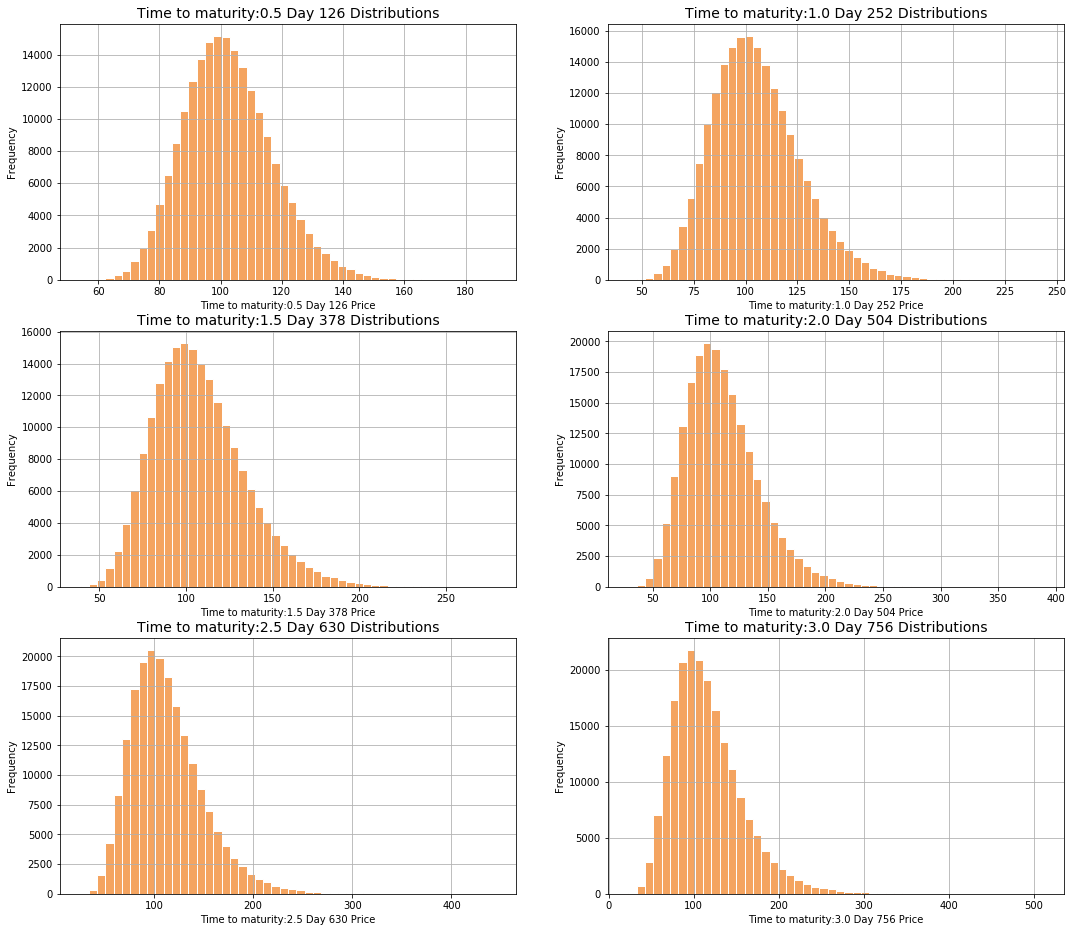

In [37]:
graph_list = [i[-1] for e, i in enumerate(spath_list)]
name_list = ["Time to maturity:{} Day {}".format(T_list[i], t_list[i]) for i in range(len(T_list))]
graph_asset_price_distribution(graph_list, name_list, 
                               rows=3, cols=2, fig_size=(18, 16), font_size=10)

The shorter the time to maturity is, the more the asset price distribution likes the normal distribution.
<br>The asset price tend to look like log normal distribution.

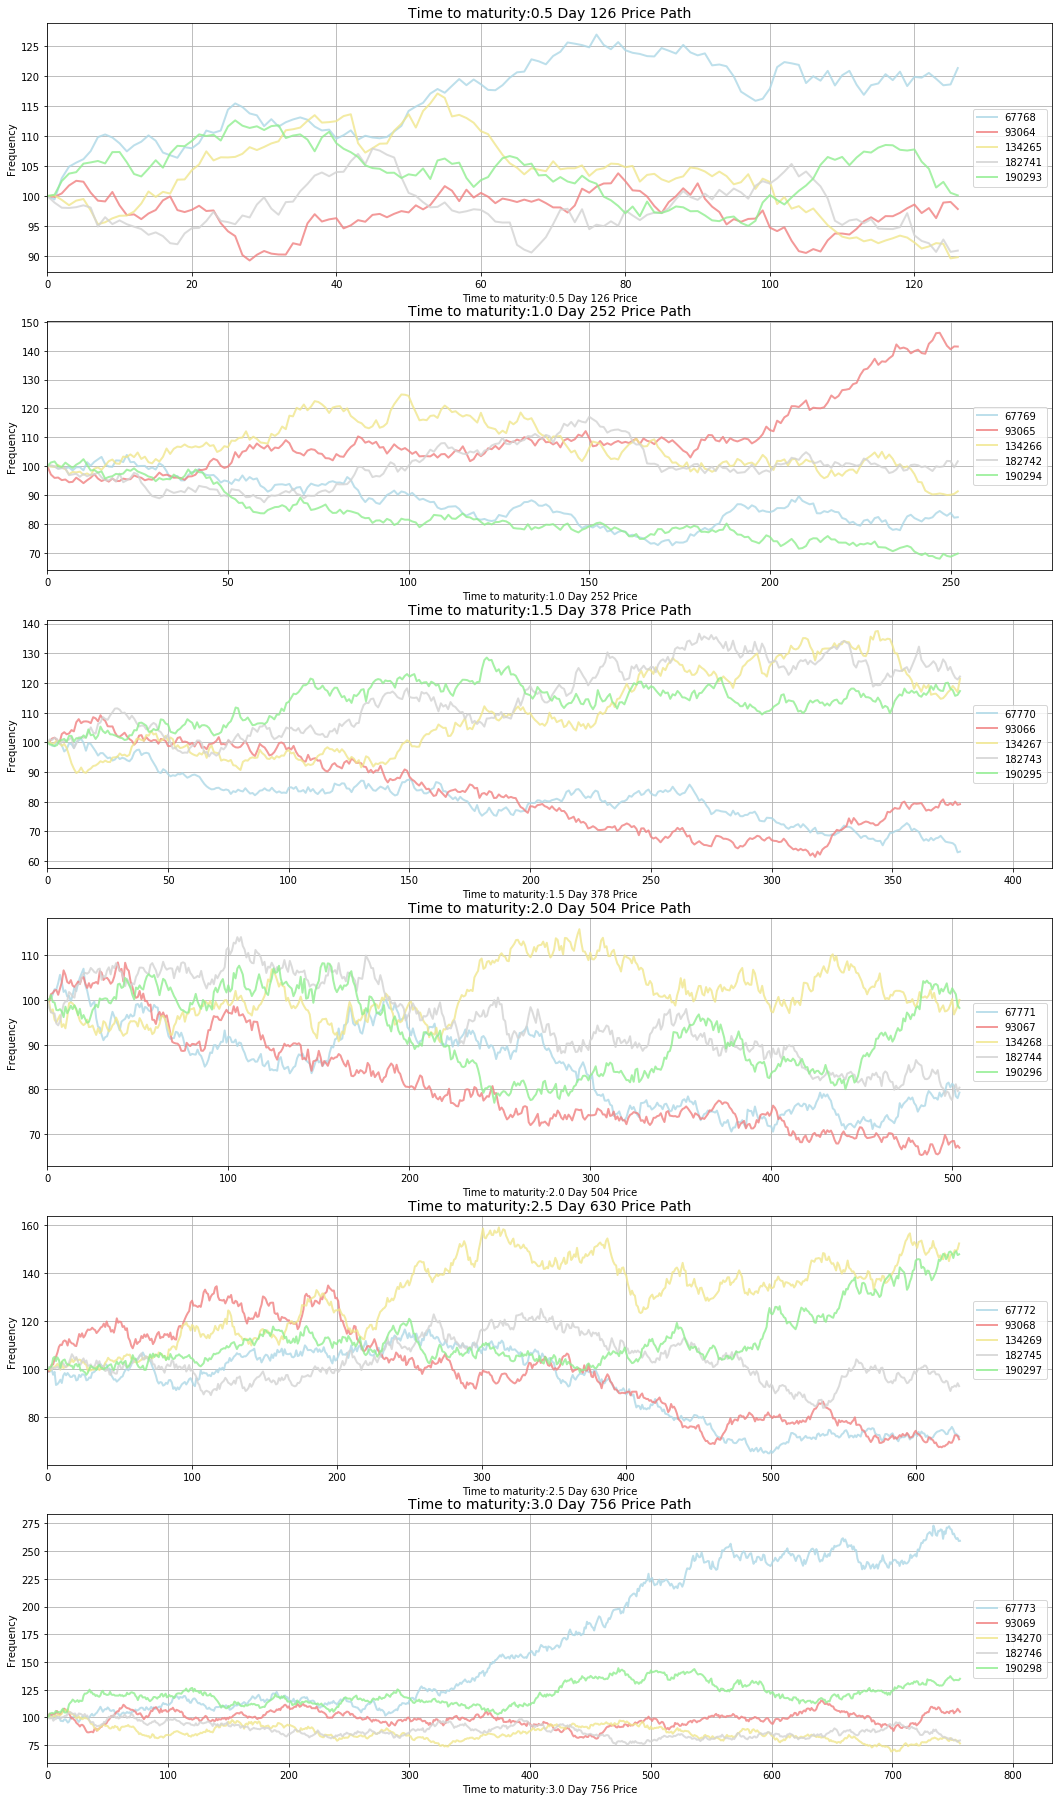

In [38]:
# Simulation with Antithetic Variance Reduction
spath_df = pd.DataFrame(spath_list[0])
picker = random_picker(n_nums=5, start=0, end=spath_df.shape[1])
graph_list = [pd.DataFrame(i).iloc[:, [min(i.shape[1], j + e) for j in picker]] for e, i in enumerate(spath_list)]
graph_simulated_GBM(graph_list, name_list, rows=6, cols=1, fig_size=(18, 32), font_size=10)

In [39]:
# # Risk Neutral Valuation
cols_arr = [
    np.array(["Asian Option", "Asian Option", "Lookback Option", "Lookback Option"]),
    np.array(["Call", "Put", "Call", "Put"])
]
T_res = pd.DataFrame(columns=cols_arr, index=pd.Series(T_list, name="Time to Maturity"))
for e, spath in enumerate(spath_list):
    print("\n===== The time to maturity is {} =====".format(T_list[e]))
    # Asian Option
    print("Asian Option:")
    asian_call, asian_put = Asian_call_put_valuation(spath, E, r, T_list[e], print_output=False)
    # Lookback Option
    print("\nLookback Option:")
    lookback_call, lookback_put = Lookback_call_put_valuation(spath, E, r, T_list[e], print_output=False)
    T_res.loc[T_list[e]] = ["%.3f"%asian_call, "%.3f"%asian_put, "%.3f"%lookback_call, "%.3f"%lookback_put]
print("With\n   current asset price is {}\n   time to maturity is {} year\n   time steps is {}\n   volatility is {}\n   risk-free rate is {}".format(S0, T, t, sigma, r))
print("\nThe Asian Options and Lookback Option call & put prices with different Time to Maturity:")
display(T_res)


===== The time to maturity is 0.5 =====
Asian Option:
----- Time diff is: 0.238471 seconds -----

Lookback Option:
----- Time diff is: 0.089086 seconds -----

===== The time to maturity is 1.0 =====
Asian Option:
----- Time diff is: 0.608527 seconds -----

Lookback Option:
----- Time diff is: 0.158049 seconds -----

===== The time to maturity is 1.5 =====
Asian Option:
----- Time diff is: 1.097584 seconds -----

Lookback Option:
----- Time diff is: 0.234323 seconds -----

===== The time to maturity is 2.0 =====
Asian Option:
----- Time diff is: 1.381728 seconds -----

Lookback Option:
----- Time diff is: 0.307935 seconds -----

===== The time to maturity is 2.5 =====
Asian Option:
----- Time diff is: 0.737679 seconds -----

Lookback Option:
----- Time diff is: 0.39636 seconds -----

===== The time to maturity is 3.0 =====
Asian Option:
----- Time diff is: 0.474618 seconds -----

Lookback Option:
----- Time diff is: 0.468975 seconds -----
With
   current asset price is 100
   time to m

Asian Option        Lookback Option        
                         Call    Put            Call     Put
Time to Maturity                                            
0.5                     3.857  2.625          12.167   8.860
1.0                     5.778  3.354          18.371  11.755
1.5                     7.354  3.777          23.410  13.550
2.0                     8.732  4.042          27.846  14.803
2.5                     9.976  4.211          31.822  15.701
3.0                    11.116  4.316          35.477  16.352

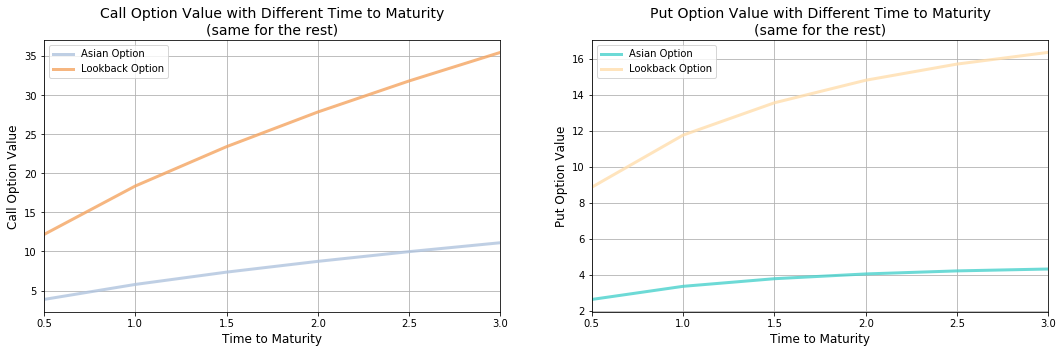

In [40]:
# Graphs of the call & put price on different strikes
x = np.array(T_res.index)
y = {
    "call": [T_res.loc[:, ("Asian Option", "Call")], T_res.loc[:, ("Lookback Option", "Call")]],
    "put": [T_res.loc[:, ("Asian Option", "Put")], T_res.loc[:, ("Lookback Option", "Put")]]
}
names = {"call": ["Asian Option", "Lookback Option"], "put": ["Asian Option", "Lookback Option"]}
graph_call_put_trend(x, y, names, "Time to Maturity", fig_size=(18, 5))

From the graphs above, we can see that, when other conditions are fixed (current asset price, Strike, volatility, and risk-free rate), there are several differences:
- Both the call and put price are positively correlated with the Time to Maturity. The longer the Time to Maturity, the more expensive the options are.
- The curve is non-linear, meaning that the option price changes in different scales as the strike changes. Both calls and puts grow rapidly with the increase of the Time to Maturity. The growth rate (slope) is <font color="red">at the peak</font> when the the Time to Maturity is at 1 year.
- The gap between calls and puts become larger with the increment of the Time to Maturity.

## 4. Volatility

In [41]:
# Settings
SIMULATION = "cont"
S0 = 100
E = 100
T = 1
t = 252
sigma_list = list(np.arange(0.05, 0.55, 0.05))
r = 0.05
N = 100000

In [42]:
# Simulate the asset price
spath_list = []
for sigma in sigma_list:
    spath_list.append(simulate_path(S0, r, sigma, T, t, N, var_reduce="Antithetic"))

===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.398201 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.427685 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.41594 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.439 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.424713 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.419534 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.416921 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 2.077458 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 2.430341 seconds -----
===== Antithetic Variance Reduct

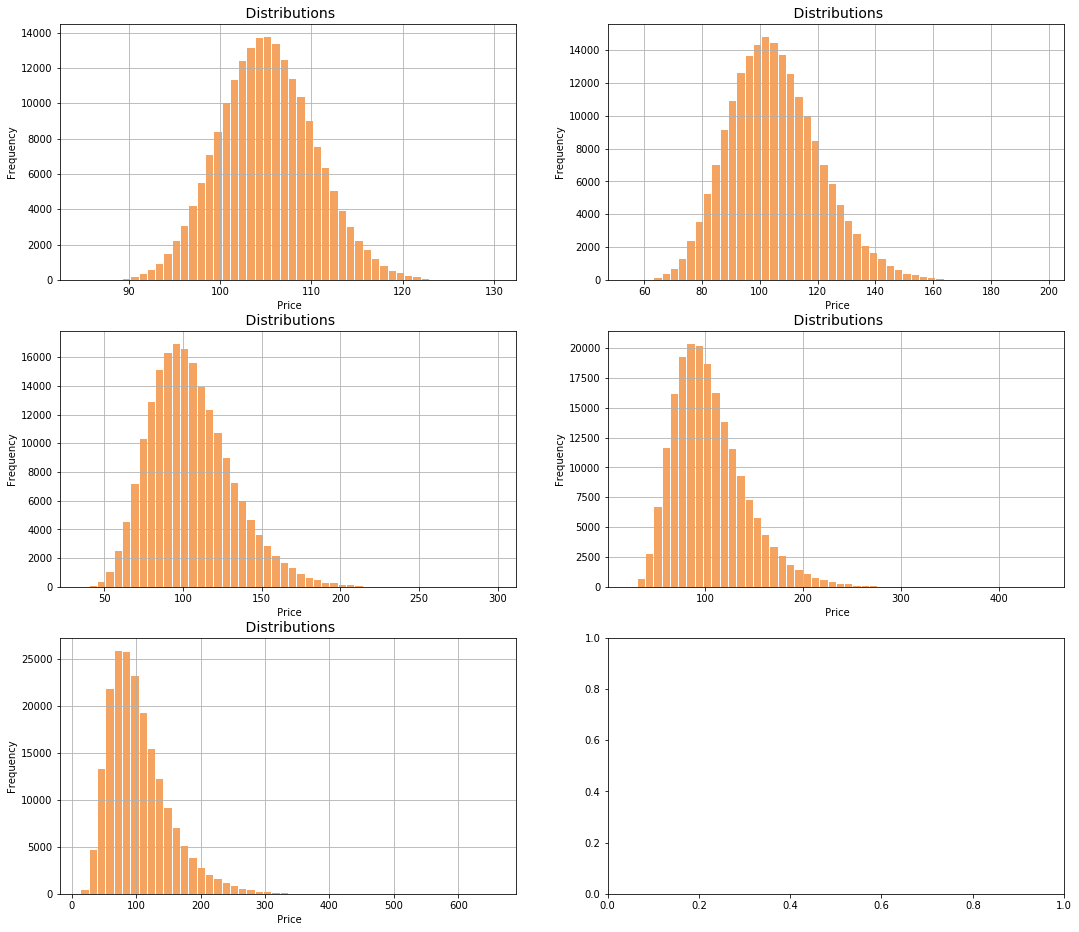

In [43]:
graph_list = [i[-1] for e, i in enumerate(spath_list) if e % 2 == 0]
name_list = ["Volatility:{} Day 252".format(i) for i in sigma_list if e % 2 == 0]
graph_asset_price_distribution(graph_list, name_list, 
                               rows=3, cols=2, fig_size=(18, 16), font_size=10)

The larger the volatility is, the more likely the asset price at time to maturity looks like log normal distribution.

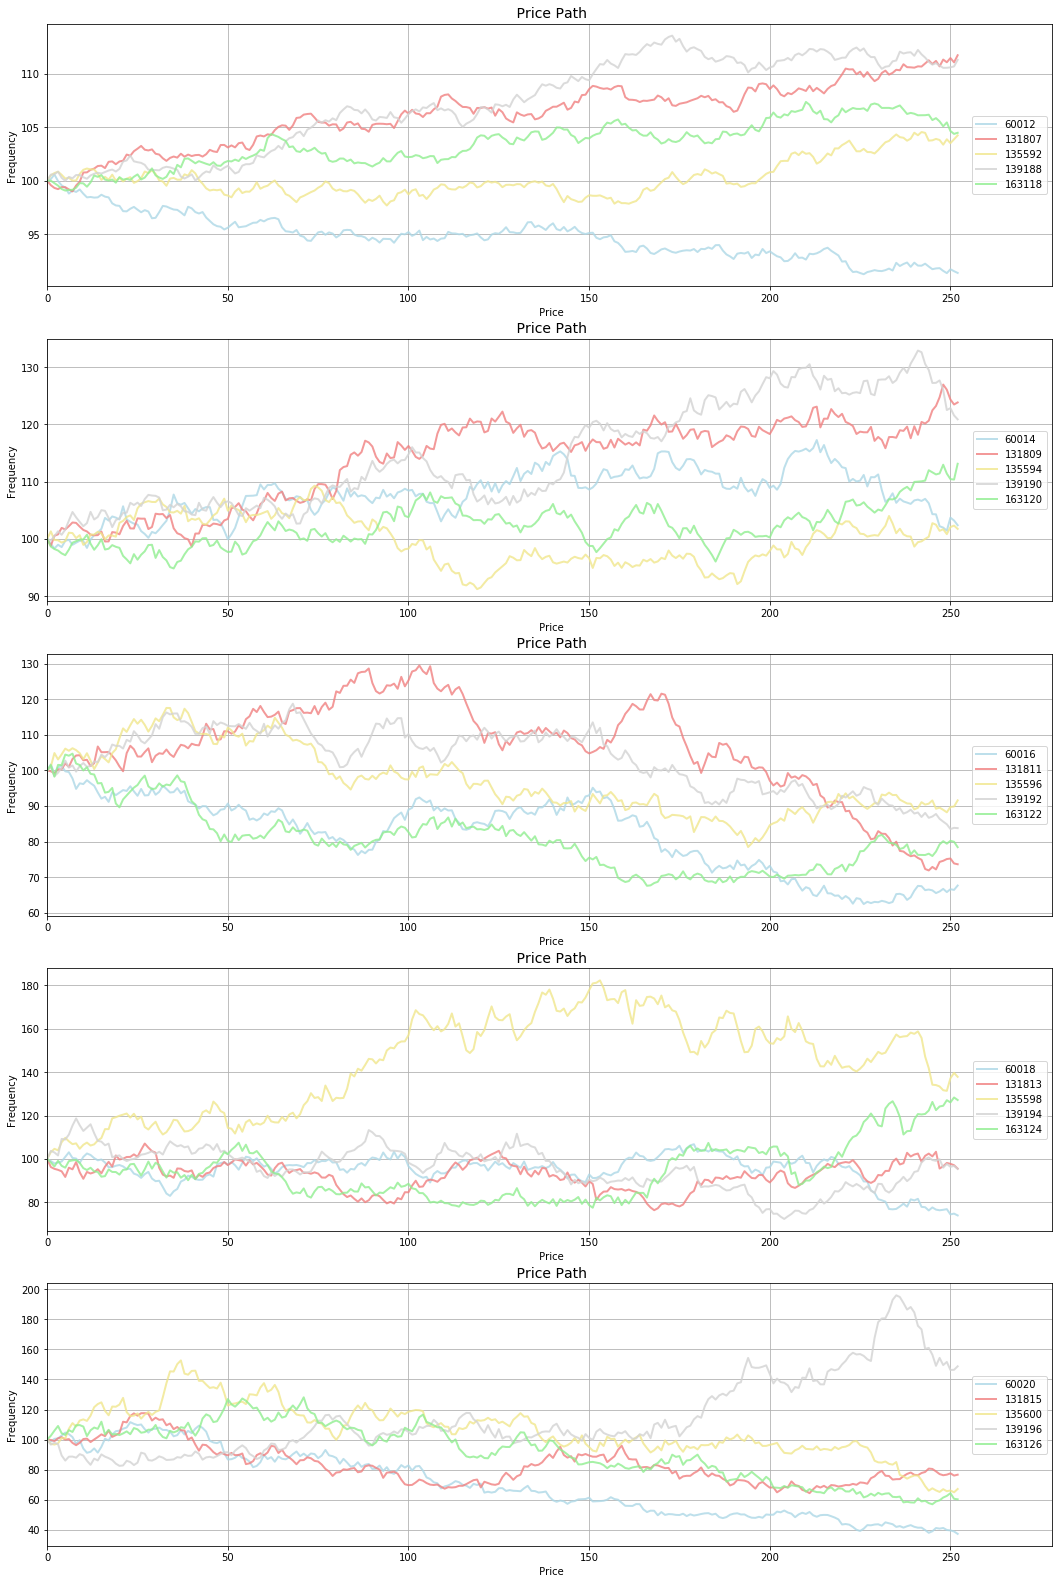

In [44]:
# Simulation with Antithetic Variance Reduction
spath_df = pd.DataFrame(spath_list[0])
picker = random_picker(n_nums=5, start=0, end=spath_df.shape[1])
graph_list = [pd.DataFrame(i).iloc[:, [min(i.shape[1], j + e) for j in picker]] for e, i in enumerate(spath_list) if e % 2 == 0]
graph_simulated_GBM(graph_list, name_list, rows=5, cols=1, fig_size=(18, 28), font_size=10)

In [45]:
# # Risk Neutral Valuation
cols_arr = [
    np.array(["Asian Option", "Asian Option", "Lookback Option", "Lookback Option"]),
    np.array(["Call", "Put", "Call", "Put"])
]
Sigma_res = pd.DataFrame(columns=cols_arr, index=pd.Series(sigma_list, name="Volatility"))
for e, spath in enumerate(spath_list):
    print("\n===== The volatility is {} =====".format(sigma_list[e]))
    # Asian Option
    print("Asian Option:")
    asian_call, asian_put = Asian_call_put_valuation(spath, E, r, T, print_output=False)
    # Lookback Option
    print("\nLookback Option:")
    lookback_call, lookback_put = Lookback_call_put_valuation(spath, E, r, T, print_output=False)
    Sigma_res.loc[sigma_list[e]] = ["%.3f"%asian_call, "%.3f"%asian_put, "%.3f"%lookback_call, "%.3f"%lookback_put]
print("With\n   current asset price is {}\n   strike is {}\n   time to maturity is {} year\n   time steps is {}\n   risk-free rate is {}".format(S0, E, T, t, r))
print("\nThe Asian Options and Lookback Option call & put prices with different Volatility:")
display(Sigma_res)


===== The volatility is 0.05 =====
Asian Option:
----- Time diff is: 0.275655 seconds -----

Lookback Option:
----- Time diff is: 0.16076 seconds -----

===== The volatility is 0.1 =====
Asian Option:
----- Time diff is: 0.293769 seconds -----

Lookback Option:
----- Time diff is: 0.149733 seconds -----

===== The volatility is 0.15000000000000002 =====
Asian Option:
----- Time diff is: 0.307344 seconds -----

Lookback Option:
----- Time diff is: 0.157463 seconds -----

===== The volatility is 0.2 =====
Asian Option:
----- Time diff is: 0.562024 seconds -----

Lookback Option:
----- Time diff is: 0.149586 seconds -----

===== The volatility is 0.25 =====
Asian Option:
----- Time diff is: 0.53912 seconds -----

Lookback Option:
----- Time diff is: 0.152072 seconds -----

===== The volatility is 0.3 =====
Asian Option:
----- Time diff is: 1.785555 seconds -----

Lookback Option:
----- Time diff is: 0.151971 seconds -----

===== The volatility is 0.35000000000000003 =====
Asian Option:
-

Asian Option        Lookback Option        
                   Call    Put            Call     Put
Volatility                                            
0.05              2.719  0.300           6.830   1.849
0.10              3.648  1.228          10.417   5.109
0.15              4.697  2.275          14.311   8.458
0.20              5.778  3.354          18.371  11.755
0.25              6.873  4.445          22.568  14.972
0.30              7.972  5.540          26.894  18.099
0.35              9.073  6.636          31.347  21.136
0.40             10.175  7.733          35.924  24.080
0.45             11.276  8.827          40.627  26.933
0.50             12.375  9.918          45.457  29.696

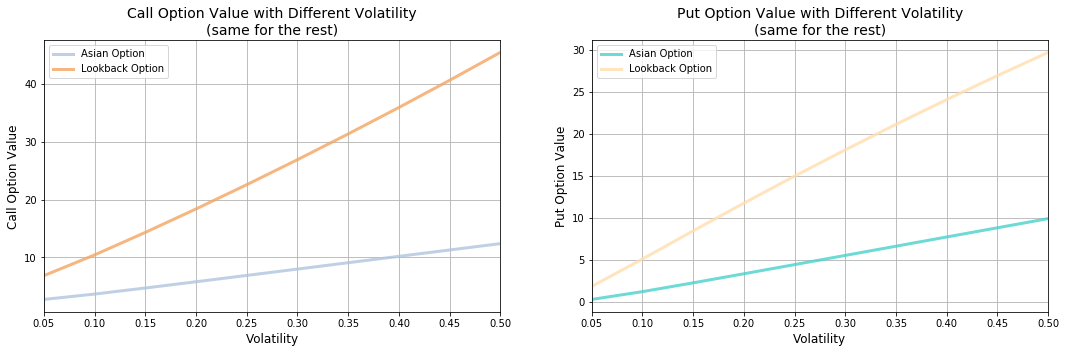

In [46]:
# Graphs of the call & put price on different strikes
x = np.array(Sigma_res.index)
y = {
    "call": [Sigma_res.loc[:, ("Asian Option", "Call")], Sigma_res.loc[:, ("Lookback Option", "Call")]],
    "put": [Sigma_res.loc[:, ("Asian Option", "Put")], Sigma_res.loc[:, ("Lookback Option", "Put")]]
}
names = {"call": ["Asian Option", "Lookback Option"], "put": ["Asian Option", "Lookback Option"]}
graph_call_put_trend(x, y, names, "Volatility", fig_size=(18, 5))

From the graphs above, we can see that, when other conditions are fixed (current asset price, Strike, Time to Maturity, and risk-free rate), there are several differences:
- Both the call and put price are positively correlated with the Time to Maturity. The larger the volatility, the more expensive the options are.
- The curve is nearly linear, meaning that the option price changes in almost the same scale as the volatility changes.
- The gap between calls and puts become larger with the increment of the volatility. The Lookback options have higher growth rate (slope) than the Asian options. <font color="mediumseagreen">However, the underlying asset price are more likely to stay in a certain range of volatility. It is very hard to get to a large volatility.</font>

## 5. Interest Rate
Since the 10-year yield of the US has been within 6% for over 10 years, and the lowest interest rate was 0.5%, we just use the range from [0.5%, 5.5%).

In [47]:
# Settings
SIMULATION = "cont"
S0 = 100
E = 100
T = 1
t = 252
sigma = 0.2
r_list = [round(i, 3) for i in np.arange(0.005, 0.06, 0.005)]
N = 100000

In [48]:
# Simulate the asset price
spath_list = []
for r in r_list:
    spath_list.append(simulate_path(S0, r, sigma, T, t, N, var_reduce="Antithetic"))

===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.376626 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.392975 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.376562 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.394242 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.406898 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.407518 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.435036 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.432903 seconds -----
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.64965 seconds -----
===== Antithetic Variance Red

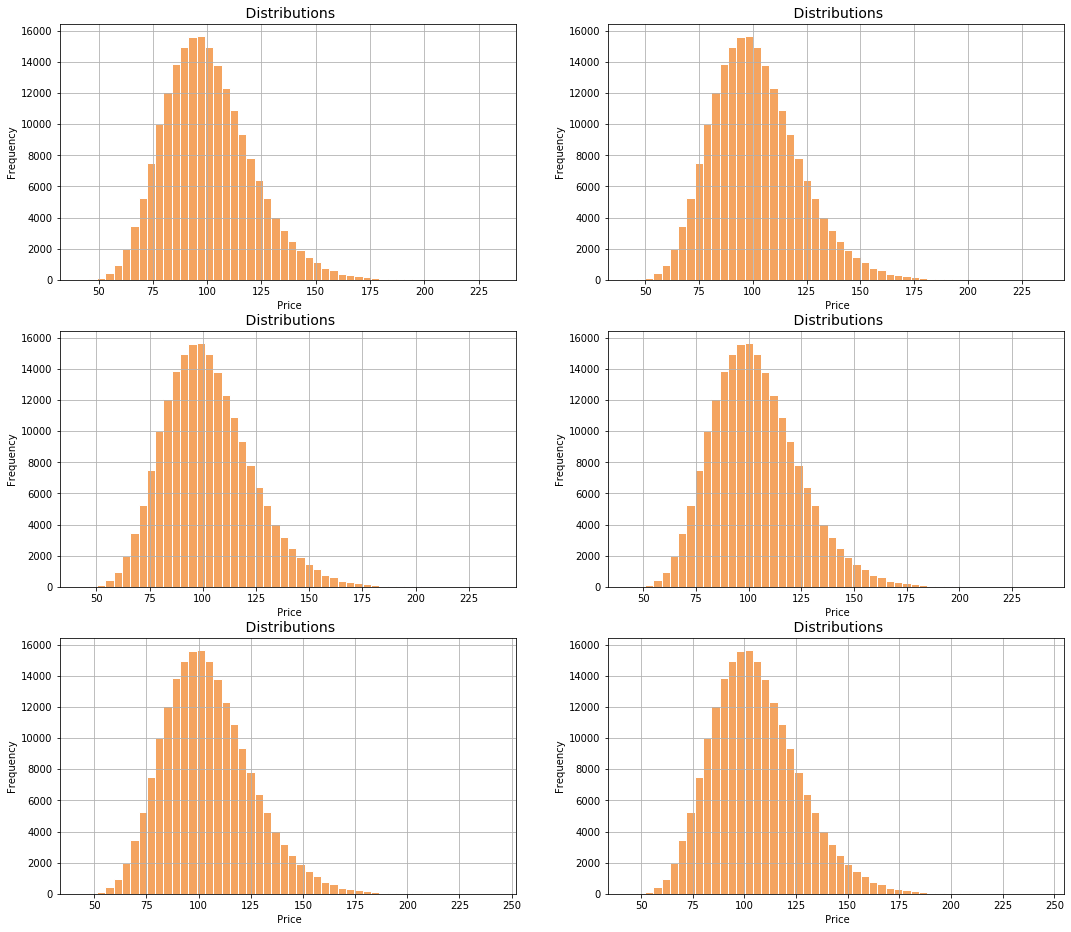

In [49]:
graph_list = [i[-1] for e, i in enumerate(spath_list) if e % 2 == 0]
name_list = ["Interest Rate:{} Day 252".format(i) for i in r_list if e % 2 == 0]
graph_asset_price_distribution(graph_list, name_list, 
                               rows=3, cols=2, fig_size=(18, 16), font_size=10)

There is a horizontal shift of the asset price on the maturity with the shift of risk-free interest rate, positively correlated. However, the shift is not that obvious.

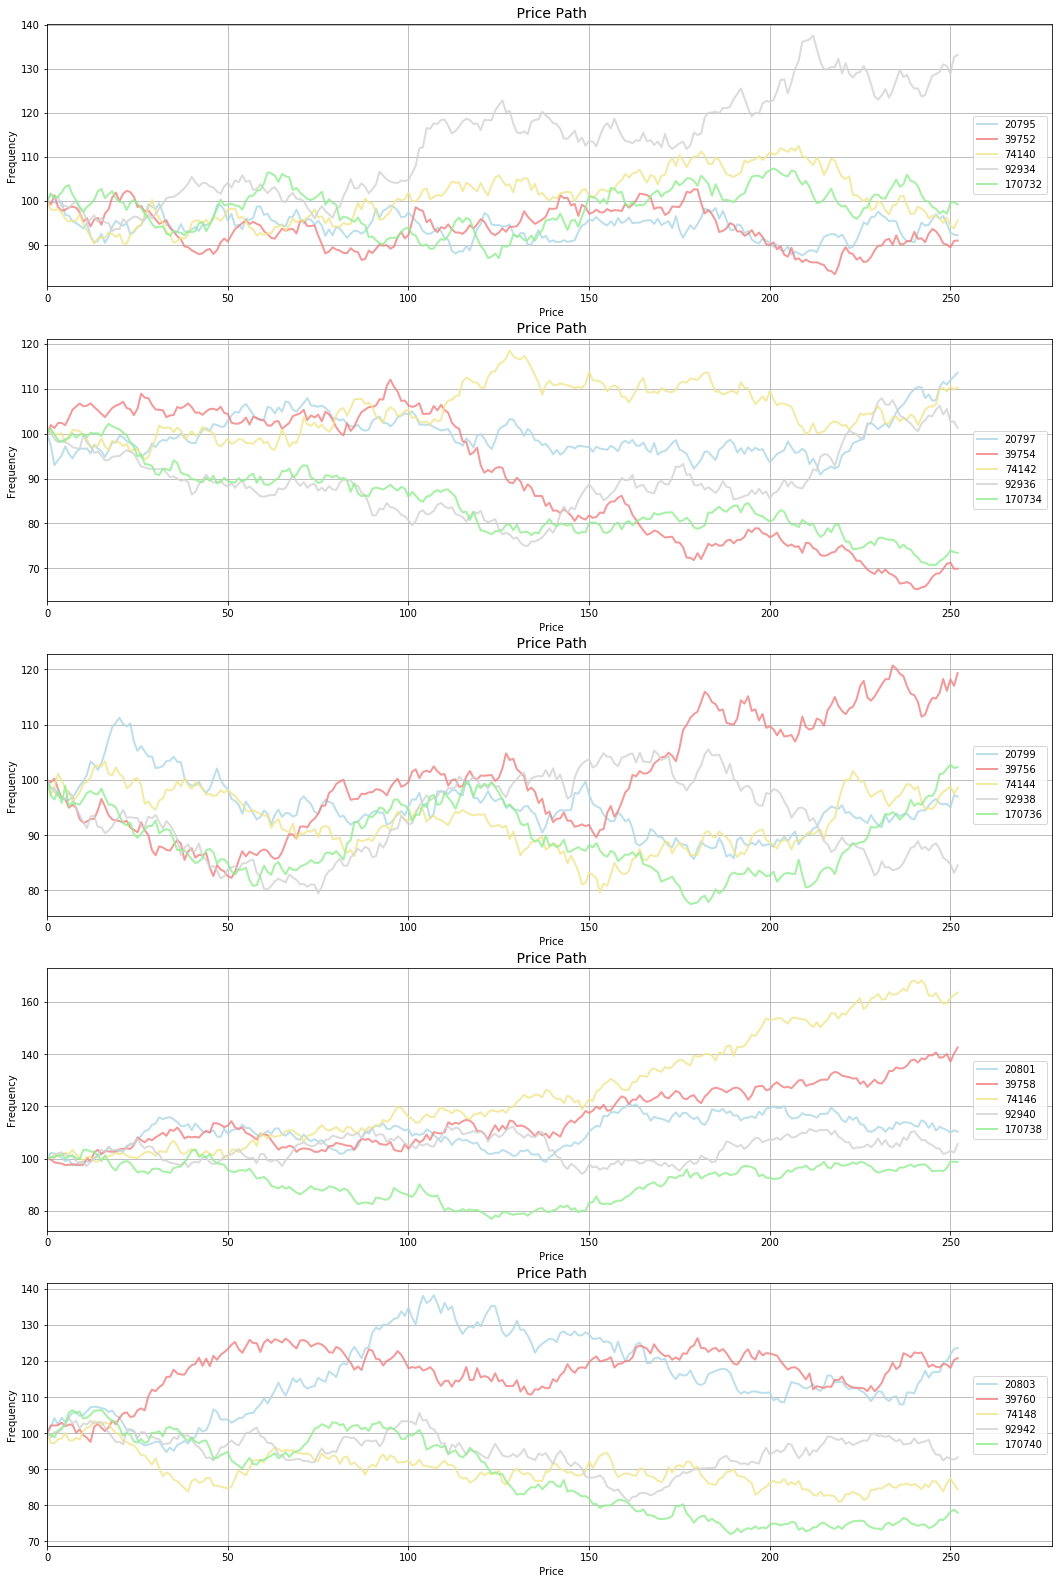

In [50]:
# Simulation with Antithetic Variance Reduction
spath_df = pd.DataFrame(spath_list[0])
picker = random_picker(n_nums=5, start=0, end=spath_df.shape[1])
graph_list = [pd.DataFrame(i).iloc[:, [min(i.shape[1], j + e) for j in picker]] for e, i in enumerate(spath_list) if e % 2 == 0]
graph_simulated_GBM(graph_list, name_list, rows=5, cols=1, fig_size=(18, 28), font_size=10)

In [51]:
# # Risk Neutral Valuation
cols_arr = [
    np.array(["Asian Option", "Asian Option", "Lookback Option", "Lookback Option"]),
    np.array(["Call", "Put", "Call", "Put"])
]
R_res = pd.DataFrame(columns=cols_arr, index=pd.Series(r_list, name="Interest Rate"))
for e, spath in enumerate(spath_list):
    print("\n===== The interest rate is {} =====".format(r_list[e]))
    # Asian Option
    print("Asian Option:")
    asian_call, asian_put = Asian_call_put_valuation(spath, E, r_list[e], T, print_output=False)
    # Lookback Option
    print("\nLookback Option:")
    lookback_call, lookback_put = Lookback_call_put_valuation(spath, E, r_list[e], T, print_output=False)
    R_res.loc[r_list[e]] = ["%.3f"%asian_call, "%.3f"%asian_put, "%.3f"%lookback_call, "%.3f"%lookback_put]
print("With\n   current asset price is {}\n   strike is {}\n   time to maturity is {} year\n   time steps is {}\n   volatility is {}".format(S0, E, T, t, sigma))
print("\nThe Asian Options and Lookback Option call & put prices with different Risk-free Interest Rate:")
display(R_res)


===== The interest rate is 0.005 =====
Asian Option:
----- Time diff is: 0.295107 seconds -----

Lookback Option:
----- Time diff is: 0.16891 seconds -----

===== The interest rate is 0.01 =====
Asian Option:
----- Time diff is: 0.321625 seconds -----

Lookback Option:
----- Time diff is: 0.165067 seconds -----

===== The interest rate is 0.015 =====
Asian Option:
----- Time diff is: 0.298463 seconds -----

Lookback Option:
----- Time diff is: 0.198138 seconds -----

===== The interest rate is 0.02 =====
Asian Option:
----- Time diff is: 0.310435 seconds -----

Lookback Option:
----- Time diff is: 0.15941 seconds -----

===== The interest rate is 0.025 =====
Asian Option:
----- Time diff is: 0.213433 seconds -----

Lookback Option:
----- Time diff is: 0.169998 seconds -----

===== The interest rate is 0.03 =====
Asian Option:
----- Time diff is: 0.778094 seconds -----

Lookback Option:
----- Time diff is: 0.226592 seconds -----

===== The interest rate is 0.035 =====
Asian Option:
---

Asian Option        Lookback Option        
                      Call    Put            Call     Put
Interest Rate                                            
0.005                4.728  4.473          16.380  14.098
0.010                4.840  4.337          16.593  13.819
0.015                4.953  4.204          16.808  13.545
0.020                5.067  4.074          17.025  13.276
0.025                5.182  3.947          17.244  13.011
0.030                5.299  3.823          17.465  12.751
0.035                5.417  3.701          17.689  12.495
0.040                5.537  3.583          17.914  12.244
0.045                5.657  3.467          18.141  11.997
0.050                5.778  3.354          18.371  11.755
0.055                5.901  3.244          18.602  11.517

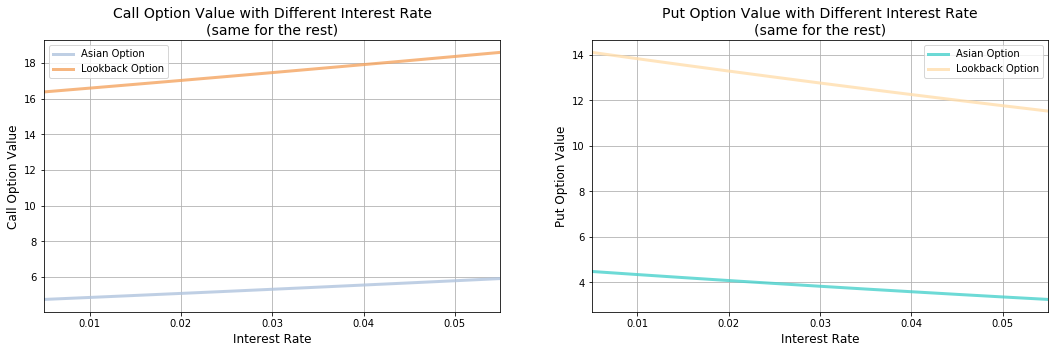

In [52]:
# Graphs of the call & put price on different strikes
x = np.array(R_res.index)
y = {
    "call": [R_res.loc[:, ("Asian Option", "Call")], R_res.loc[:, ("Lookback Option", "Call")]],
    "put": [R_res.loc[:, ("Asian Option", "Put")], R_res.loc[:, ("Lookback Option", "Put")]]
}
names = {"call": ["Asian Option", "Lookback Option"], "put": ["Asian Option", "Lookback Option"]}
graph_call_put_trend(x, y, names, "Interest Rate", fig_size=(18, 5))

From the graphs above, we can see that, when other conditions are fixed (current asset price, Strike, Time to Maturity, and volatility), there are several differences:
- Both the call and put price are positively correlated with the Time to Maturity. The longer the Time to Maturity, the more expensive the options are.
- The curve is linear, meaning that the option price changes in the same scale as the strike changes.
- The gap between Asian calls Lookback calls becomes larger as the interest rate grows, while the gap between Asian puts and Lookback puts becomes smaller.
- The gap between Asian options and Lookback options are quite great compared to other parameters. The gaps in calls are greater than the one in puts.

## 6. Simulation times (N)
The purpose is to see the option price difference as well as testing the time consumption increment with the simulation times (N).

In [53]:
# Settings
SIMULATION = "cont"
S0 = 100
E = 100
T = 1
t = 252
sigma = 0.2
r = 0.05
N_list = [10 ** i for i in range(1, 7)]

In [54]:
# Simulate the asset price
spath_list = []
for N in N_list:
    print("{} times Monte Carlo Simulations.".format(N))
    spath_list.append(simulate_path(S0, r, sigma, T, t, N, var_reduce="Antithetic"))
    print("")

10 times Monte Carlo Simulations.
===== Antithetic Variance Reduction =====
new data:(253, 20)
----- Time diff is: 0.008832 seconds -----

100 times Monte Carlo Simulations.
===== Antithetic Variance Reduction =====
new data:(253, 200)
----- Time diff is: 0.006932 seconds -----

1000 times Monte Carlo Simulations.
===== Antithetic Variance Reduction =====
new data:(253, 2000)
----- Time diff is: 0.018863 seconds -----

10000 times Monte Carlo Simulations.
===== Antithetic Variance Reduction =====
new data:(253, 20000)
----- Time diff is: 0.140377 seconds -----

100000 times Monte Carlo Simulations.
===== Antithetic Variance Reduction =====
new data:(253, 200000)
----- Time diff is: 1.451084 seconds -----

1000000 times Monte Carlo Simulations.
===== Antithetic Variance Reduction =====
new data:(253, 2000000)
----- Time diff is: 19.779549 seconds -----



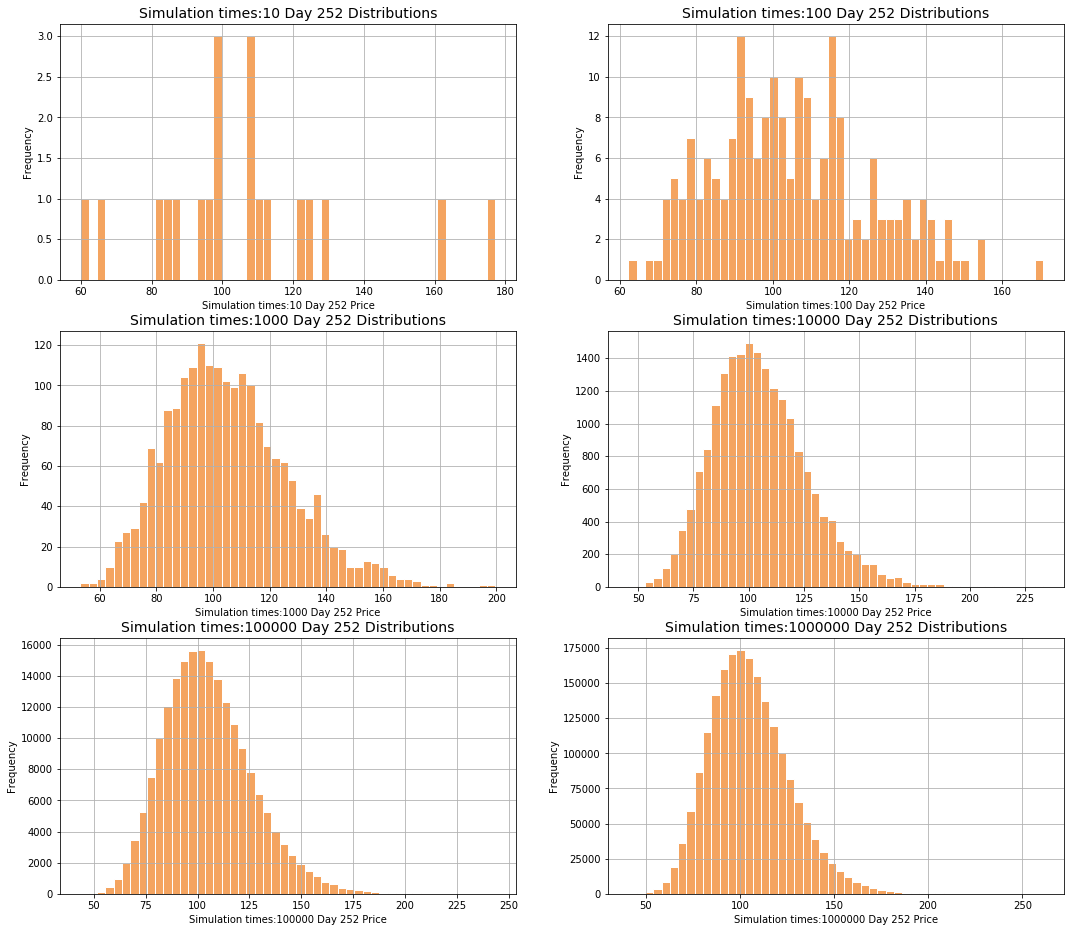

In [55]:
graph_list = [i[-1] for i in spath_list]
name_list = ["Simulation times:{} Day 252".format(i) for i in N_list]
graph_asset_price_distribution(graph_list, name_list, 
                               rows=3, cols=2, fig_size=(18, 16), font_size=10)

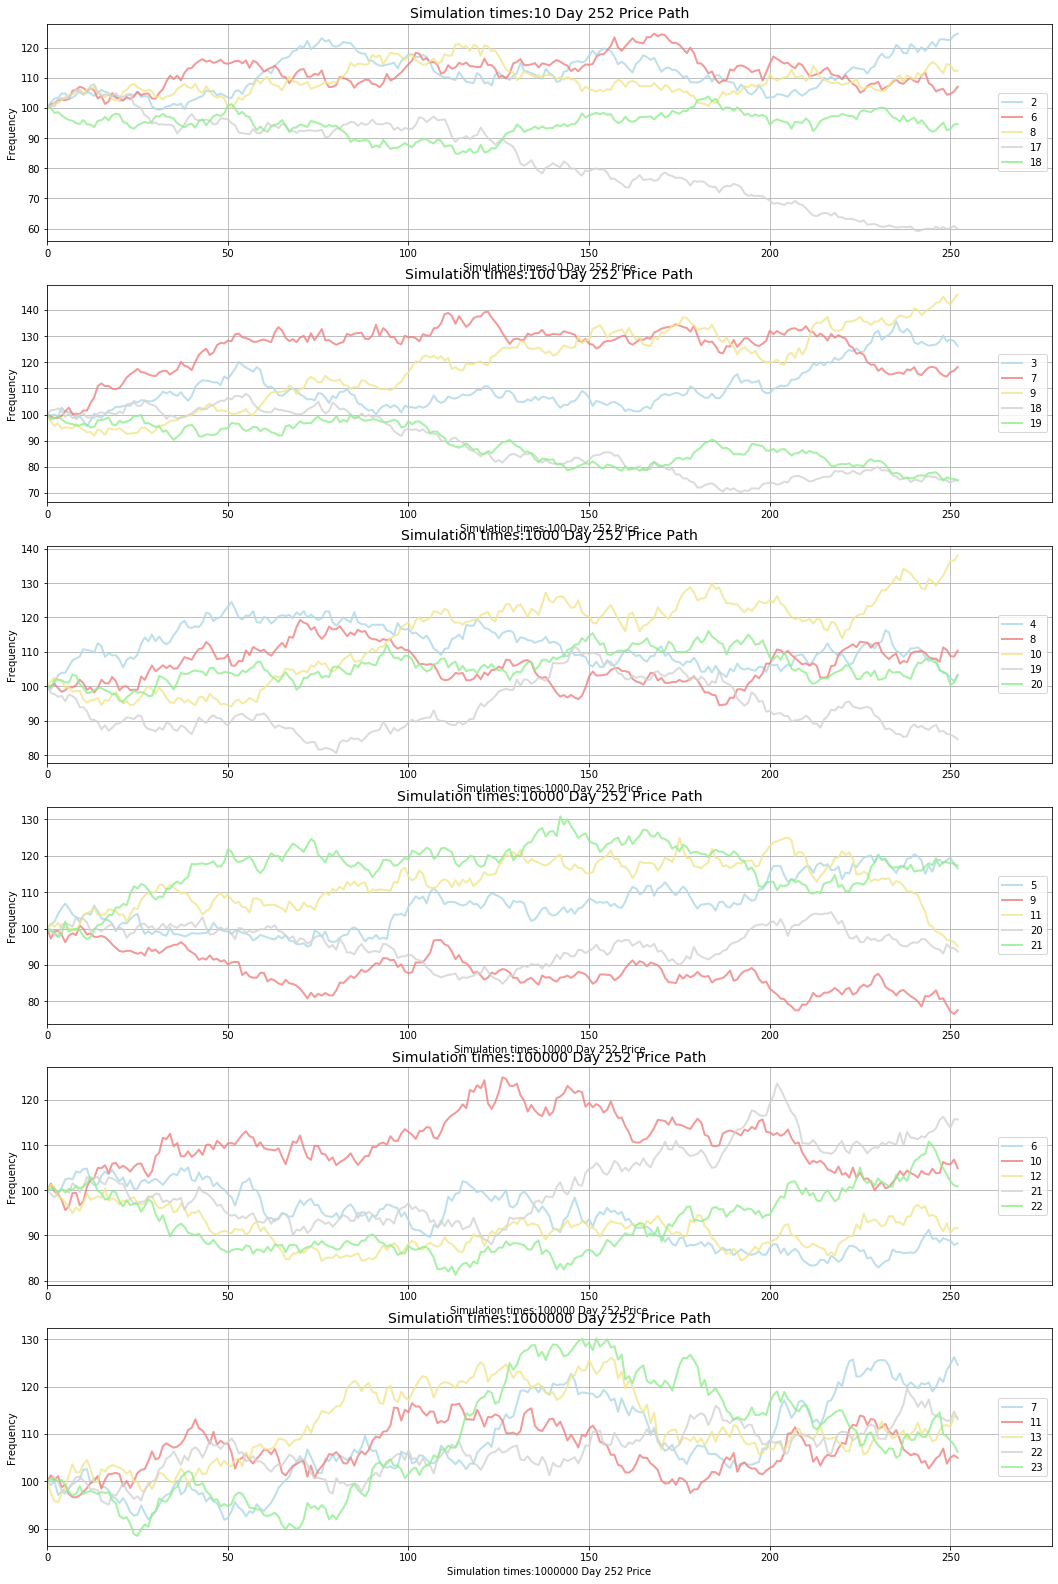

In [57]:
# Simulation with Antithetic Variance Reduction
spath_df = pd.DataFrame(spath_list[0])
picker = random_picker(n_nums=5, start=0, end=spath_df.shape[1])
graph_list = [pd.DataFrame(i).iloc[:, [min(i.shape[1], j + e) for j in picker]] for e, i in enumerate(spath_list)]
graph_simulated_GBM(graph_list, name_list, rows=6, cols=1, fig_size=(18, 28), font_size=10)

In [58]:
# # Risk Neutral Valuation
cols_arr = [
    np.array(["Asian Option", "Asian Option", "Lookback Option", "Lookback Option"]),
    np.array(["Call", "Put", "Call", "Put"])
]
N_res = pd.DataFrame(columns=cols_arr, index=pd.Series(N_list, name="Simultion times"))
for e, spath in enumerate(spath_list):
    print("\n===== {} simulation times =====".format(N_list[e]))
    # Asian Option
    print("Asian Options:")
    asian_call, asian_put = Asian_call_put_valuation(spath, E, r, T, print_output=False)
    # Lookback Option
    print("\nLookback Options:")
    lookback_call, lookback_put = Lookback_call_put_valuation(spath, E, r, T, print_output=False)
    N_res.loc[N_list[e]] = ["%.3f"%asian_call, "%.3f"%asian_put, "%.3f"%lookback_call, "%.3f"%lookback_put]
print("With\n   current asset price is {}\n   strike is {}\n   time to maturity is {} year\n   time steps is {}\n   volatility is {}".format(S0, E, T, t, sigma))
print("\nThe Asian Options and Lookback Option call & put prices with different Simultion times:")
display(N_res)


===== 10 simulation times =====
Asian Options:
----- Time diff is: 0.000147 seconds -----

Lookback Options:
----- Time diff is: 0.000243 seconds -----

===== 100 simulation times =====
Asian Options:
----- Time diff is: 0.000261 seconds -----

Lookback Options:
----- Time diff is: 0.000454 seconds -----

===== 1000 simulation times =====
Asian Options:
----- Time diff is: 0.006698 seconds -----

Lookback Options:
----- Time diff is: 0.001899 seconds -----

===== 10000 simulation times =====
Asian Options:
----- Time diff is: 0.087146 seconds -----

Lookback Options:
----- Time diff is: 0.016214 seconds -----

===== 100000 simulation times =====
Asian Options:
----- Time diff is: 1.332229 seconds -----

Lookback Options:
----- Time diff is: 0.187647 seconds -----

===== 1000000 simulation times =====
Asian Options:
----- Time diff is: 5.106406 seconds -----

Lookback Options:
----- Time diff is: 1.769298 seconds -----
With
   current asset price is 100
   strike is 100
   time to matu

Asian Option        Lookback Option        
                        Call    Put            Call     Put
Simultion times                                            
10                     6.396  3.804          19.557  12.213
100                    5.701  3.346          18.214  11.742
1000                   5.600  3.227          18.396  11.821
10000                  5.843  3.396          18.457  11.779
100000                 5.778  3.354          18.371  11.755
1000000                5.758  3.341          18.346  11.741

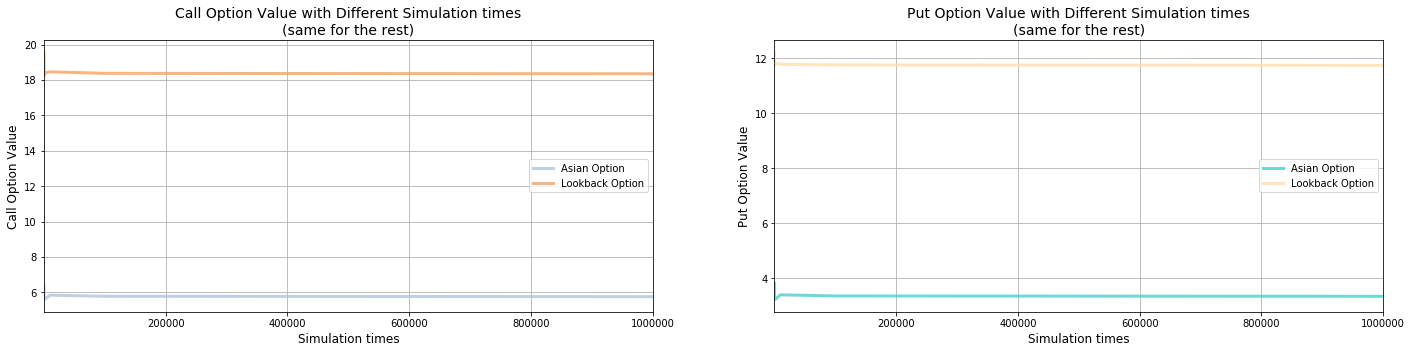

In [59]:
# Graphs of the call & put price on different strikes
x = np.array(N_res.index)
y = {
    "call": [N_res.loc[:, ("Asian Option", "Call")], N_res.loc[:, ("Lookback Option", "Call")]],
    "put": [N_res.loc[:, ("Asian Option", "Put")], N_res.loc[:, ("Lookback Option", "Put")]]
}
names = {"call": ["Asian Option", "Lookback Option"], "put": ["Asian Option", "Lookback Option"]}
graph_call_put_trend(x, y, names, "Simulation times", fig_size=(24, 5))

From the graphs and the table above, we can see that, when other conditions are fixed (current asset price, Strike, Time to Maturity, volatility, and interest rate), there are several differences with the change of simulation times:
- The less the simulation times, the less likely the maturity asset price is lognormally distributed.
- The less the simulation times, the further it is away from the theoretical option price.
- When the simulation times reaches 100000, the simulation result becomes stable.
- However, simulation is time consuming. With the increment of simulation times, the time it takes to simulate the maturity asset price increases exponentially.

# Conclusions

### Observations

- The change of the options prices according to different parameters are shown below:

|           Parameters           |     Call     |     Put      |
| :----------------------------: | :----------: | :----------: |
| Underlying Asset Price ($S_0$) |  $\uparrow$  | $\downarrow$ |
|          Strike ($E$)          | $\downarrow$ |  $\uparrow$  |
|   Time to Maturity ($\tau$)    |  $\uparrow$  |  $\uparrow$  |
|     Volatility ($\sigma$)      |  $\uparrow$  |  $\uparrow$  |
| Risk-free Interest Rate ($r$)  |  $\uparrow$  | $\downarrow$ |

- **With the increment of simulation times, the simulation will become exponentially time consuming.**
    - Ten times the simulation times, the time spent on simulation will increase in about exponential of 2 times.
    - When the simulation times is above 10000, the simulation result becomes stable.
- **The price of the Asian options are always lower than the Lookback options.**
    - The Lookback options always give the buyer the 'best' price, leading to more benefits. However, the Asian options tends to lower the higher prices and higher the lower prices.
    - This is natually the characteristic of Asian options. Because they are the average price of the previous asset price. Average smooths the trend, which leads to lower volatility natually. However, the Lookback options are always the 'best' price, which is less path dependent and volatile more.
- **The Lookback options prices tend to volatile more than the Asian options prices.**
    - This may owe to the greater volatility of the pricing objective in Lookback options.
- **The option prices changes may in different scales.**
    - The underlying asset price, strike, time to maturity, and interest rate tends to affect the options price in different scales. However, the others almost have linear relationship with the option price.

### Potential Problems

- The Monte Carlo Simulation can be slow if the scale is large.
- If the hardware does not support the computation, the Monte Carlo Simulation cannot go on, or even bring down the machine.
    <br>I was not able to deliver a $10^7$ simulation times.
- The valuation process can be time consuming with lots of parameters combinations.

# Reference

- Yves Hilpisch. (2019). Python for Finance (2nd ed.). Sebastopol, CA: O'Reilly Media, Inc.
- Karl Sigman (2007). Retrieved from http://www.columbia.edu/~ks20/4703-Sigman/4703-07-Notes-ATV.pdf.
- Martin Haugh. (2017). Simulation Efficiency and an Introduction to Variance Reduction Methods. IEOR E4703. Retrieved from http://www.columbia.edu/~mh2078/MonteCarlo/MCS_Var_Red_Basic.pdf.
- Gordon Scott (2021, August 25). Lookback Option. Retrieved from https://www.investopedia.com/terms/l/lookbackoption.asp.
- James Chen (2021, February 17). Asian Option. Retrieved from https://www.investopedia.com/terms/a/asianoption.asp.
- (Wikipedia). Euler–Maruyama method. Retrieved from https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method.